# Data Science for Adult Dataset, 

inspired by https://github.com/dformoso/sklearn-classification/blob/master/Data%20Science%20Workbook%20-%20Census%20Income%20Dataset.ipynb

In [1]:
import io, os, sys, types, time, datetime, math, random, requests, subprocess, tempfile


In [2]:
from io import StringIO

In [3]:
# Data Manipulation 
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

# Feature Selection and Encoding
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning 
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

#comment tensorflow out
#import tensorflow as tf

# Grid and Random Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plot the Figures Inline
%matplotlib inline

In [4]:
	
# Download
ADULT_DATASET = (
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
)

def download_data(path, urls):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        response = requests.get(url)
        name = os.path.basename(url)
        with open(os.path.join(path, name), 'wb') as f:
            f.write(response.content)

data_path = "../data/Adult_data"
urls = ADULT_DATASET

#download_data(data_path, urls)

In [5]:
# Load Training and Test Data Sets
headers = ['age', 'workclass', 'fnlwgt', 
           'education', 'education-num', 
           'marital-status', 'occupation', 
           'relationship', 'race', 'sex', 
           'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 
           'predclass']

training_raw = pd.read_csv(os.path.join(data_path, 'adult.data'), 
                       header=None, 
                       names=headers, 
                       sep=',\s', 
                       na_values=["?"], 
                       engine='python')
test_raw = pd.read_csv(os.path.join(data_path, 'adult.test'), 
                      header=None, 
                      names=headers, 
                      sep=',\s', 
                      na_values=["?"], 
                      engine='python', 
                      skiprows=1)

In [6]:
#join datasets
dataset_raw = pd.concat([training_raw, test_raw], ignore_index=True)

In [7]:
#List features 
dataset_raw.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'predclass'],
      dtype='object')

In [8]:
# Displaying the size of the Dataframe in Memory
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("Bytes", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])
convert_size(dataset_raw.memory_usage().sum())

'5.59 MB'

In [9]:
# Describing all the Numerical Features
dataset_raw.describe()

age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

In [10]:
len(dataset_raw)

48842

In [11]:
# Describing all the Categorical Features
dataset_raw.describe(include=['O'])

workclass education      marital-status      occupation relationship  \
count      46043     48842               48842           46033        48842   
unique         8        16                   7              14            6   
top      Private   HS-grad  Married-civ-spouse  Prof-specialty      Husband   
freq       33906     15784               22379            6172        19716   

         race    sex native-country predclass  
count   48842  48842          47985     48842  
unique      5      2             41         4  
top     White   Male  United-States     <=50K  
freq    41762  32650          43832     24720

In [12]:
# Let's have a quick look at our data
dataset_raw.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country predclass  
0          2174             0              40  United-States     <=50K  
1             0             0              13  United-States     <=50K  
2             0             0              40  United-States     <=50K  
3             0             0              40  United-States     <=50K  
4             0             0              40           Cuba     <=50K

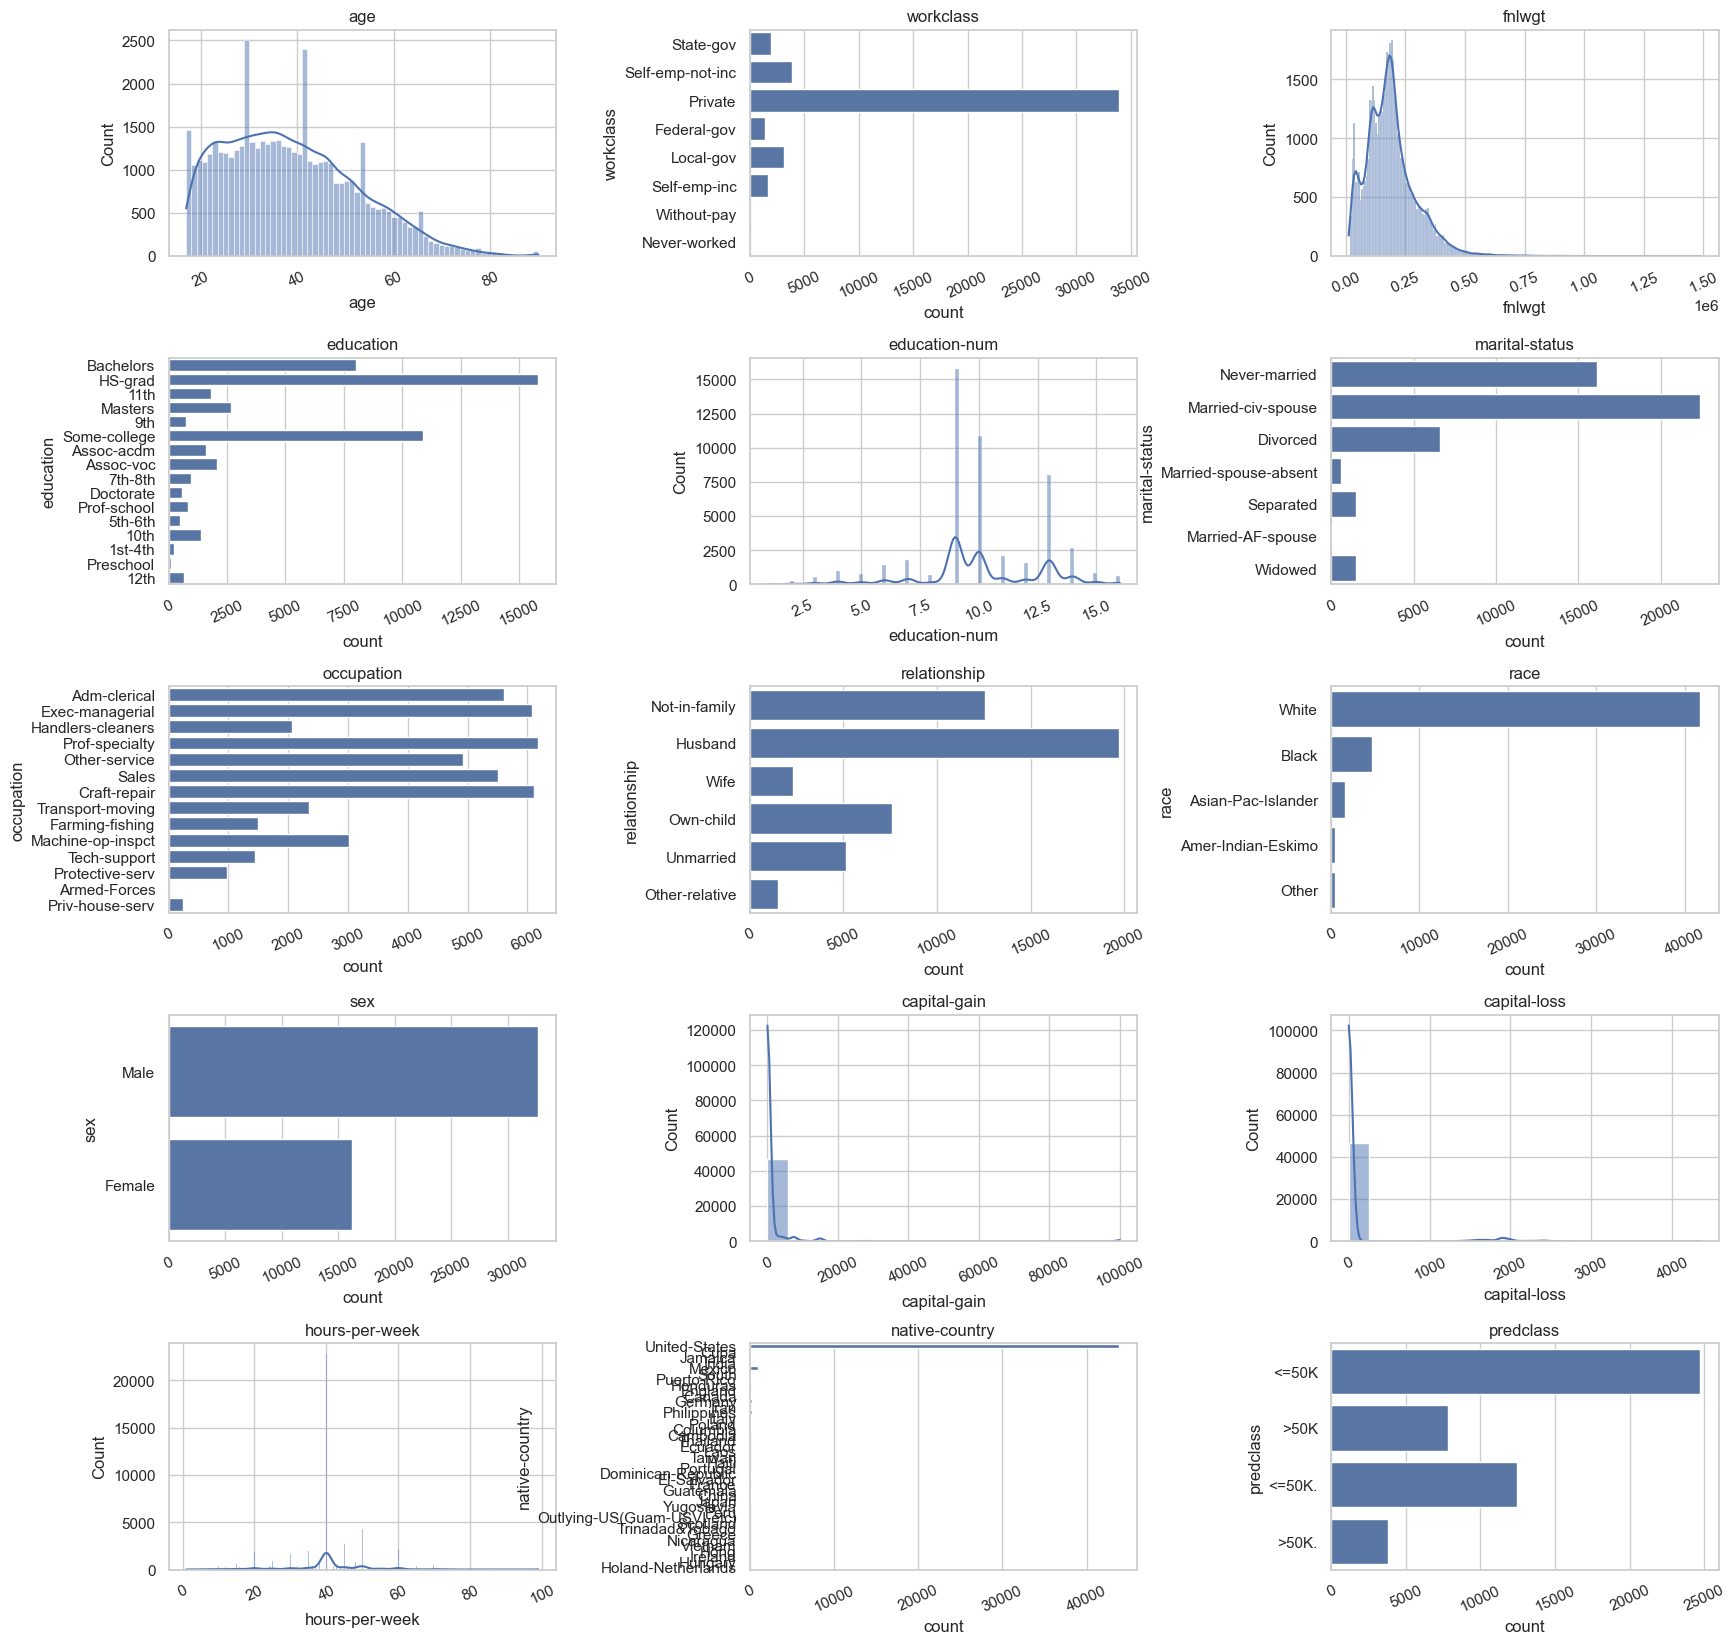

In [13]:


def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    sns.set_theme(style='whitegrid')  # Use seaborn to set the theme
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        
        # Check if the column is categorical (object type) or continuous
        if dataset.dtypes[column] == object:
            sns.countplot(y=column, data=dataset, ax=ax)  # Use seaborn's countplot for categorical data
            plt.xticks(rotation=25)
        else:
            sns.histplot(data=dataset, x=column, kde=True, ax=ax)  # Use seaborn's histplot for continuous data
            plt.xticks(rotation=25)
    
plot_distribution(dataset_raw, cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

<Axes: >

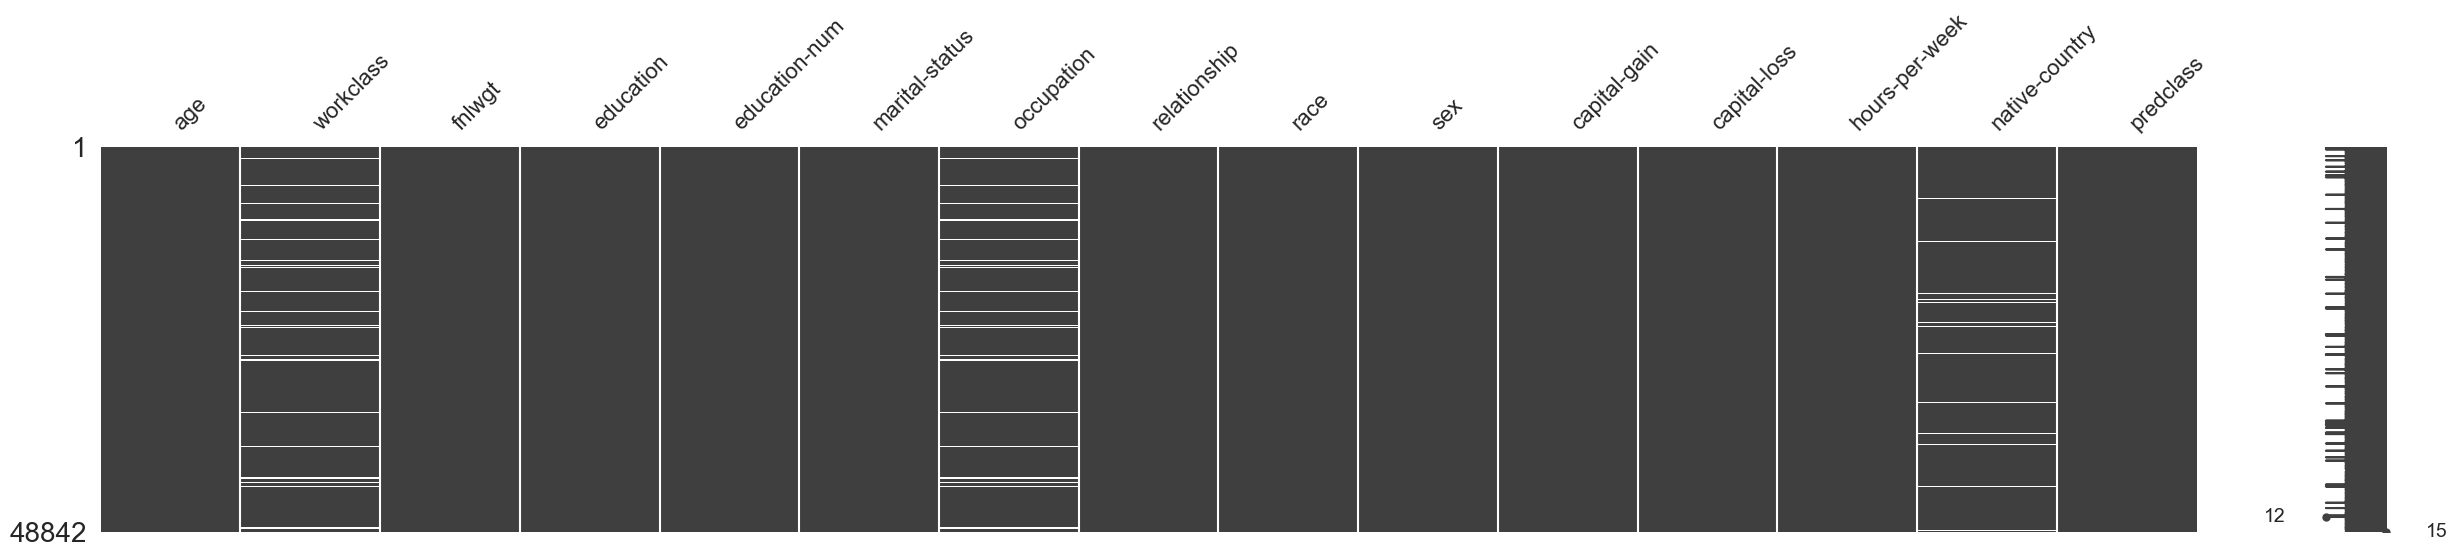

In [14]:
# How many missing values are there in our dataset?
missingno.matrix(dataset_raw, figsize = (30,5))

<Axes: >

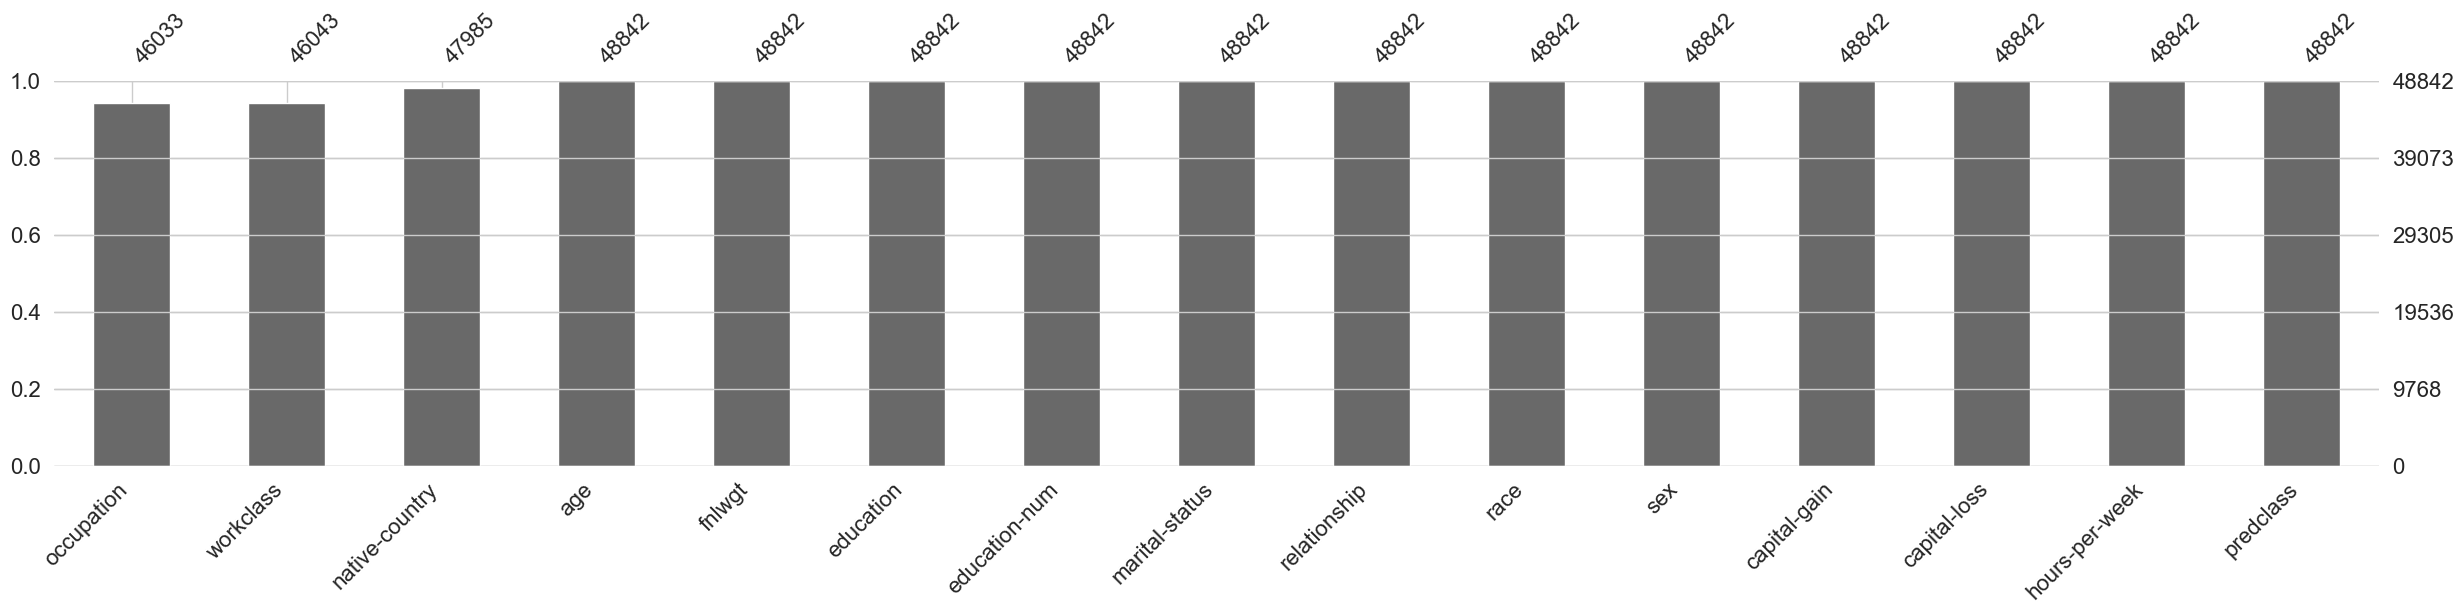

In [15]:
missingno.bar(dataset_raw, sort='ascending', figsize = (30,5))

## Feature clearning, engineering and imputatation

### Feature: Predclass

In [16]:
# To perform our data analysis, let's create new dataframes.
dataset_bin = pd.DataFrame() # To contain our dataframe with our discretised continuous variables 
dataset_con = pd.DataFrame() # To contain our dataframe with our continuous variables 

In [17]:
# Let's fix the Class Feature, change string to binary 0/1. Where 1 is singifes that individual is earning above $50K
dataset_raw.loc[dataset_raw['predclass'] == '>50K', 'predclass'] = 1
dataset_raw.loc[dataset_raw['predclass'] == '>50K.', 'predclass'] = 1
dataset_raw.loc[dataset_raw['predclass'] == '<=50K', 'predclass'] = 0
dataset_raw.loc[dataset_raw['predclass'] == '<=50K.', 'predclass'] = 0

dataset_bin['predclass'] = dataset_raw['predclass']
dataset_con['predclass'] = dataset_raw['predclass']

<Axes: xlabel='count', ylabel='predclass'>

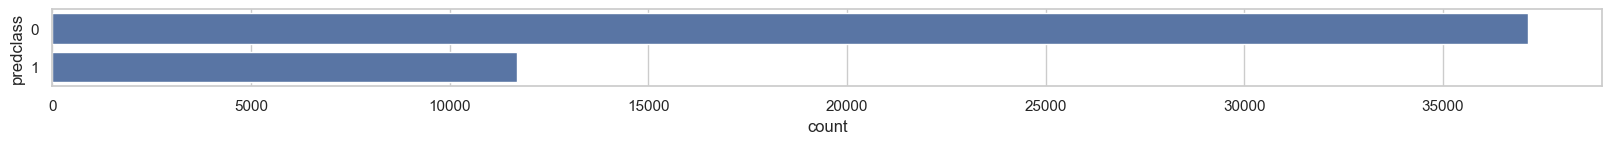

In [18]:


# Now, you can proceed to create your plot
fig = plt.figure(figsize=(20,1)) 
sns.countplot(y="predclass", data=dataset_bin)

### Feature: Age

In [19]:
#cut age into equally sized buckets
dataset_bin['age'] = pd.cut(dataset_raw['age'], 10) # discretised 
dataset_con['age'] = dataset_raw['age'] # non-discretised

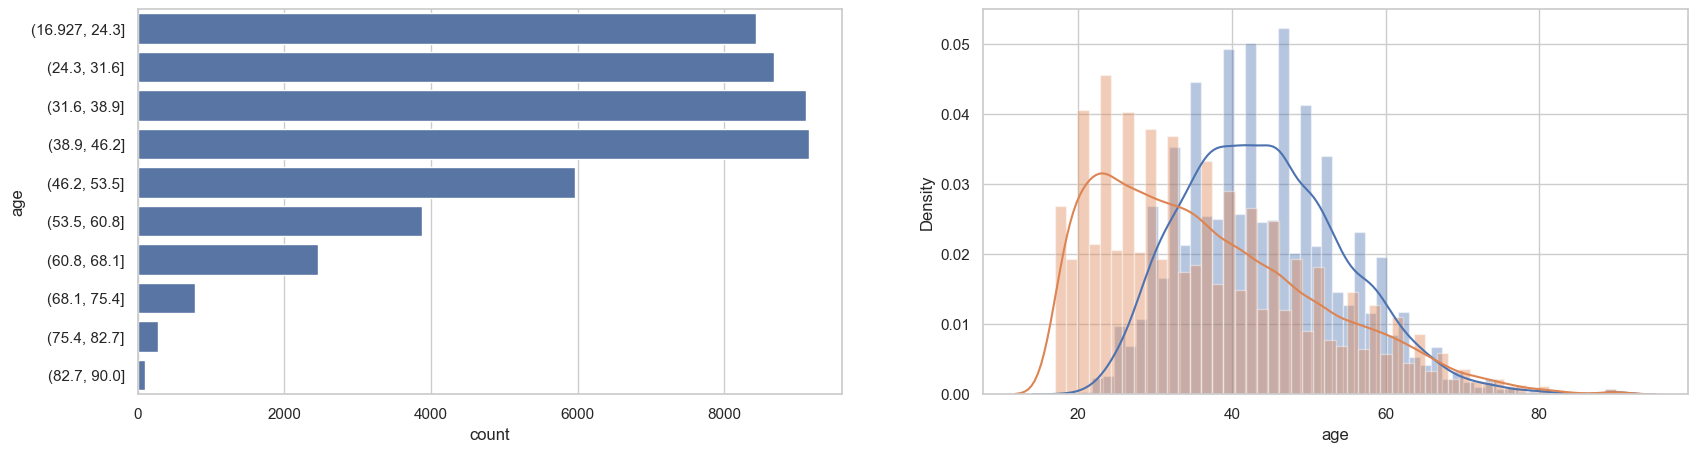

In [20]:
fig = plt.figure(figsize=(20,5)) 
plt.subplot(1, 2, 1)
sns.countplot(y="age", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 1]['age'], kde_kws={"label": ">$50K"});
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 0]['age'], kde_kws={"label": "<$50K"});

### Feature: Workclass

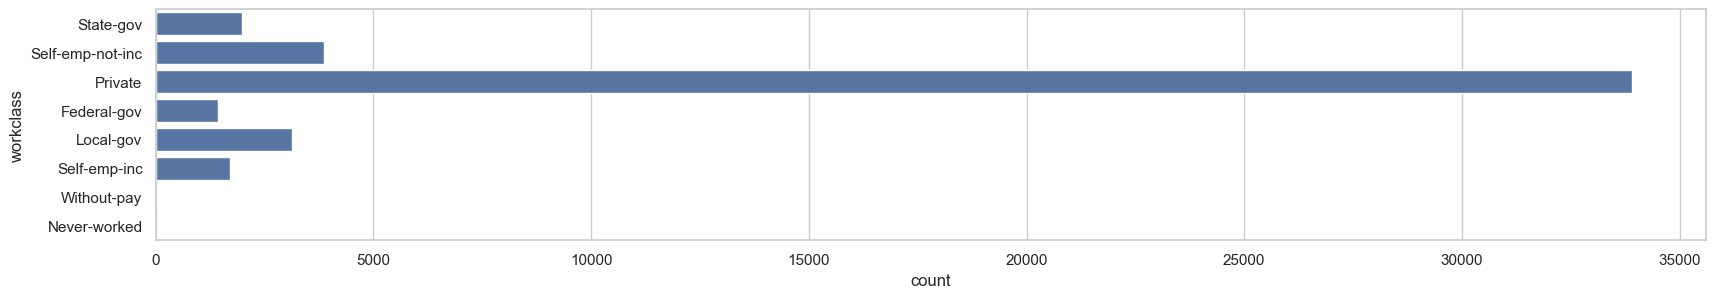

In [21]:
# Can we bucket some of these groups?
plt.figure(figsize=(20,3)) 
sns.countplot(y="workclass", data=dataset_raw);

In [22]:
# There are too many groups here, we can group someof them together.
# Create buckets for Workclass
dataset_raw.loc[dataset_raw['workclass'] == 'Without-pay', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass'] == 'Never-worked', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass'] == 'Federal-gov', 'workclass'] = 'Fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'State-gov', 'workclass'] = 'Non-fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'Local-gov', 'workclass'] = 'Non-fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'Self-emp-not-inc', 'workclass'] = 'Self-emp'
dataset_raw.loc[dataset_raw['workclass'] == 'Self-emp-inc', 'workclass'] = 'Self-emp'

dataset_bin['workclass'] = dataset_raw['workclass']
dataset_con['workclass'] = dataset_raw['workclass']

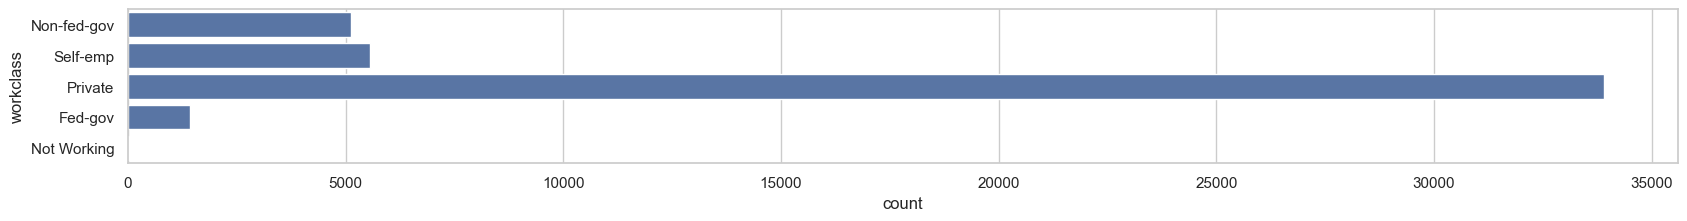

In [23]:
fig = plt.figure(figsize=(20,2))
sns.countplot(y="workclass", data=dataset_bin);

### Feature: Occupation

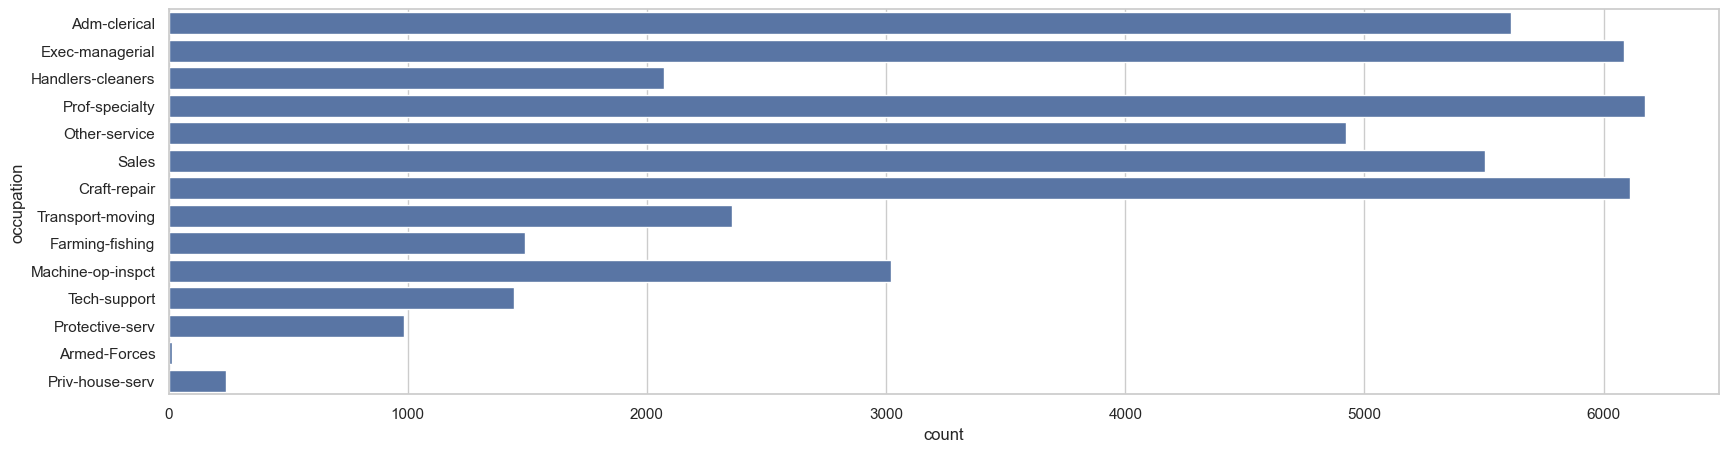

In [24]:
plt.figure(figsize=(20,5)) 
sns.countplot(y="occupation", data=dataset_raw);

In [25]:
# Create buckets for Occupation
dataset_raw.loc[dataset_raw['occupation'] == 'Adm-clerical', 'occupation'] = 'Admin'
dataset_raw.loc[dataset_raw['occupation'] == 'Armed-Forces', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation'] == 'Craft-repair', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Exec-managerial', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Farming-fishing', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Handlers-cleaners', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Machine-op-inspct', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Other-service', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation'] == 'Priv-house-serv', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation'] == 'Prof-specialty', 'occupation'] = 'Professional'
dataset_raw.loc[dataset_raw['occupation'] == 'Protective-serv', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation'] == 'Sales', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Tech-support', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Transport-moving', 'occupation'] = 'Manual Labour'

dataset_bin['occupation'] = dataset_raw['occupation']
dataset_con['occupation'] = dataset_raw['occupation']

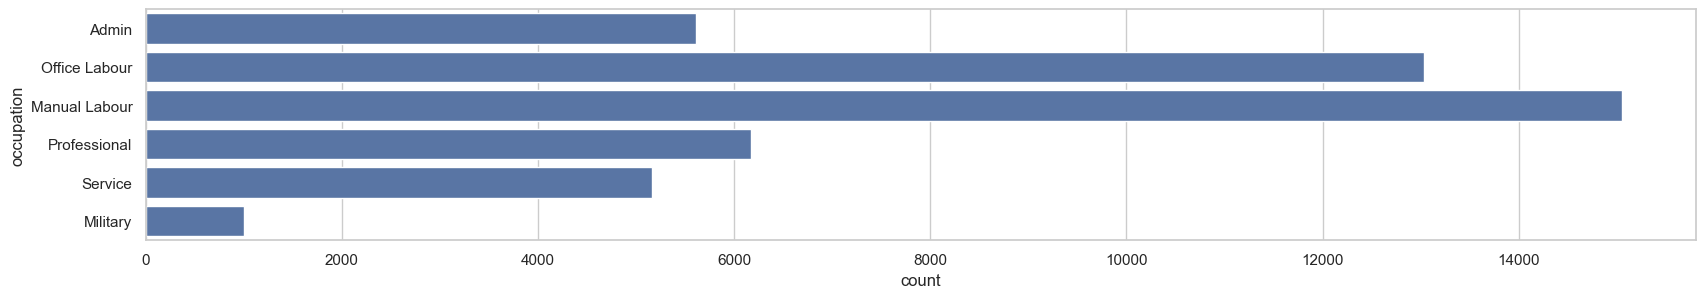

In [26]:
fig = plt.figure(figsize=(20,3))
sns.countplot(y="occupation", data=dataset_bin);

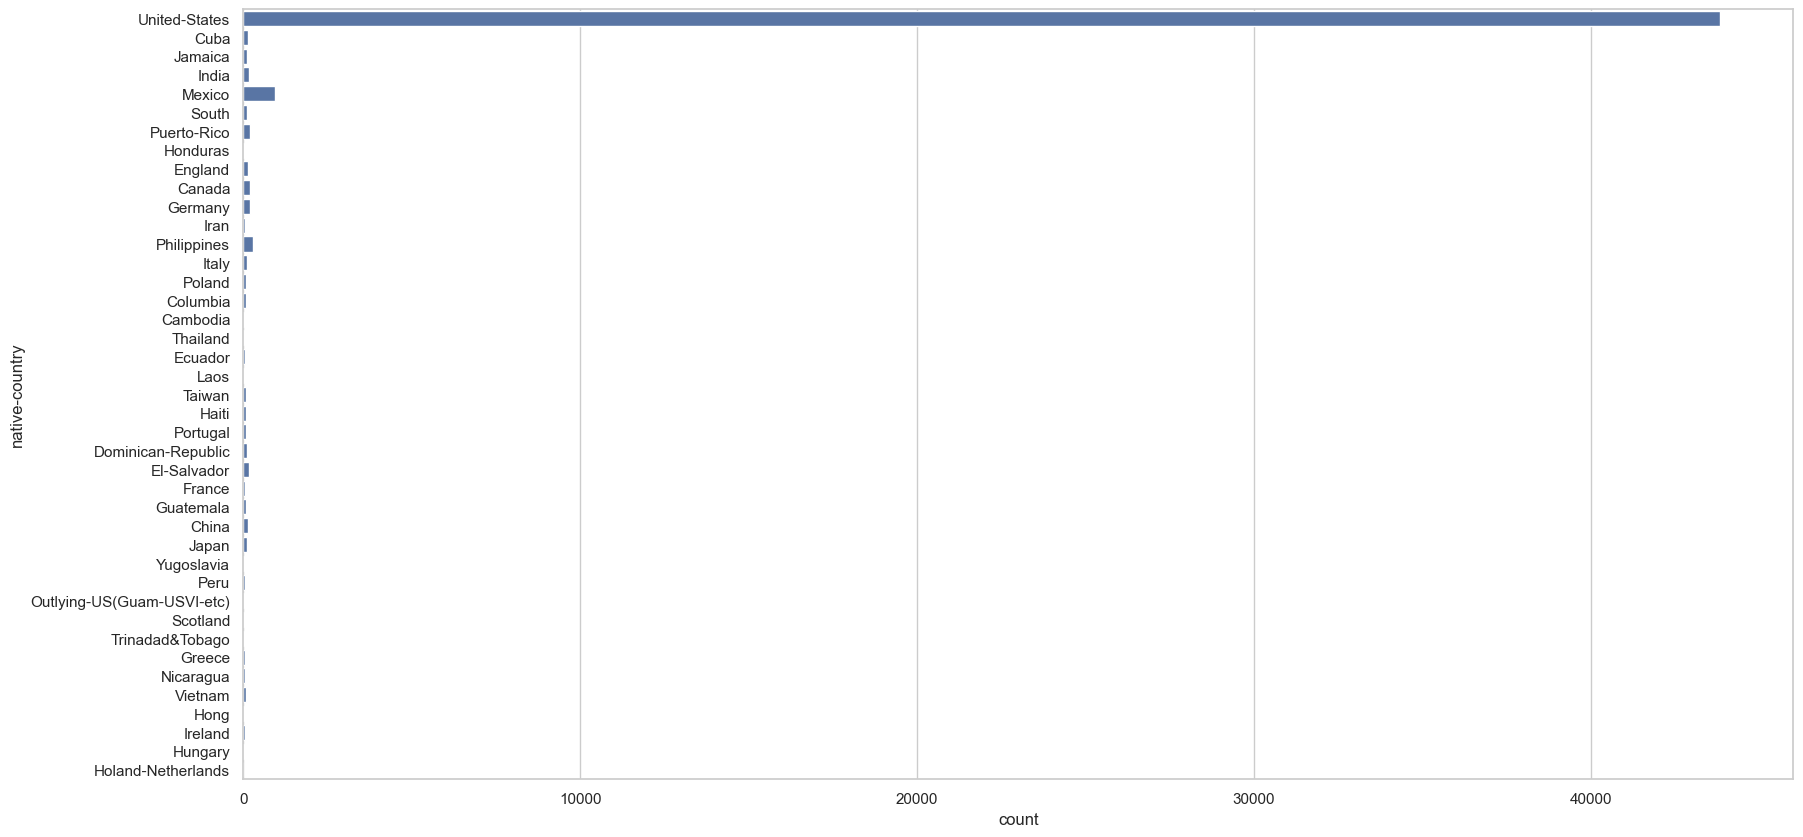

In [27]:
plt.figure(figsize=(20,10)) 
sns.countplot(y="native-country", data=dataset_raw);

In [28]:
#get rid of most/all other countries
dataset_raw.loc[dataset_raw['native-country'] == 'Cambodia'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Canada'                      , 'native-country'] = 'British-Commonwealth'    
dataset_raw.loc[dataset_raw['native-country'] == 'China'                       , 'native-country'] = 'China'       
dataset_raw.loc[dataset_raw['native-country'] == 'Columbia'                    , 'native-country'] = 'South-America'    
dataset_raw.loc[dataset_raw['native-country'] == 'Cuba'                        , 'native-country'] = 'South-America'        
dataset_raw.loc[dataset_raw['native-country'] == 'Dominican-Republic'          , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Ecuador'                     , 'native-country'] = 'South-America'     
dataset_raw.loc[dataset_raw['native-country'] == 'El-Salvador'                 , 'native-country'] = 'South-America' 
dataset_raw.loc[dataset_raw['native-country'] == 'England'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'France'                      , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Germany'                     , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Greece'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Guatemala'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Haiti'                       , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Holand-Netherlands'          , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Honduras'                    , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Hong'                        , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == 'Hungary'                     , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'India'                       , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'Iran'                        , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Ireland'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'Italy'                       , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Jamaica'                     , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Japan'                       , 'native-country'] = 'APAC'
dataset_raw.loc[dataset_raw['native-country'] == 'Laos'                        , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Mexico'                      , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Nicaragua'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Outlying-US(Guam-USVI-etc)'  , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Peru'                        , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Philippines'                 , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Poland'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Portugal'                    , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Puerto-Rico'                 , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Scotland'                    , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'South'                       , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Taiwan'                      , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == 'Thailand'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Trinadad&Tobago'             , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'United-States'               , 'native-country'] = 'United-States'
dataset_raw.loc[dataset_raw['native-country'] == 'Vietnam'                     , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Yugoslavia'                  , 'native-country'] = 'Euro_Group_2'

dataset_bin['native-country'] = dataset_raw['native-country']
dataset_con['native-country'] = dataset_raw['native-country']

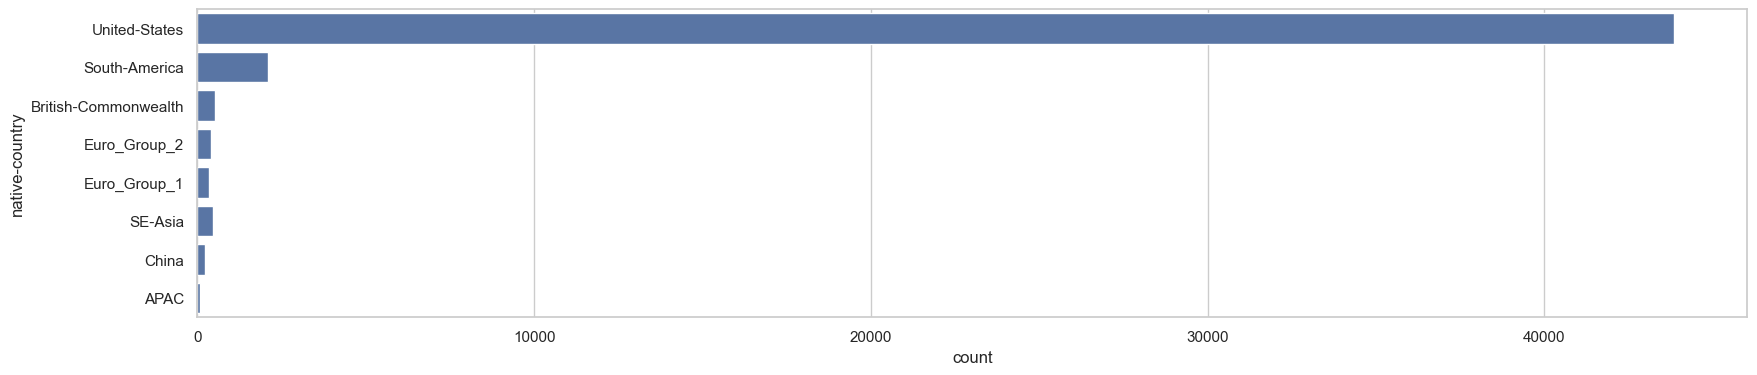

In [29]:
fig = plt.figure(figsize=(20,4)) 
sns.countplot(y="native-country", data=dataset_bin);

### Feature: Education

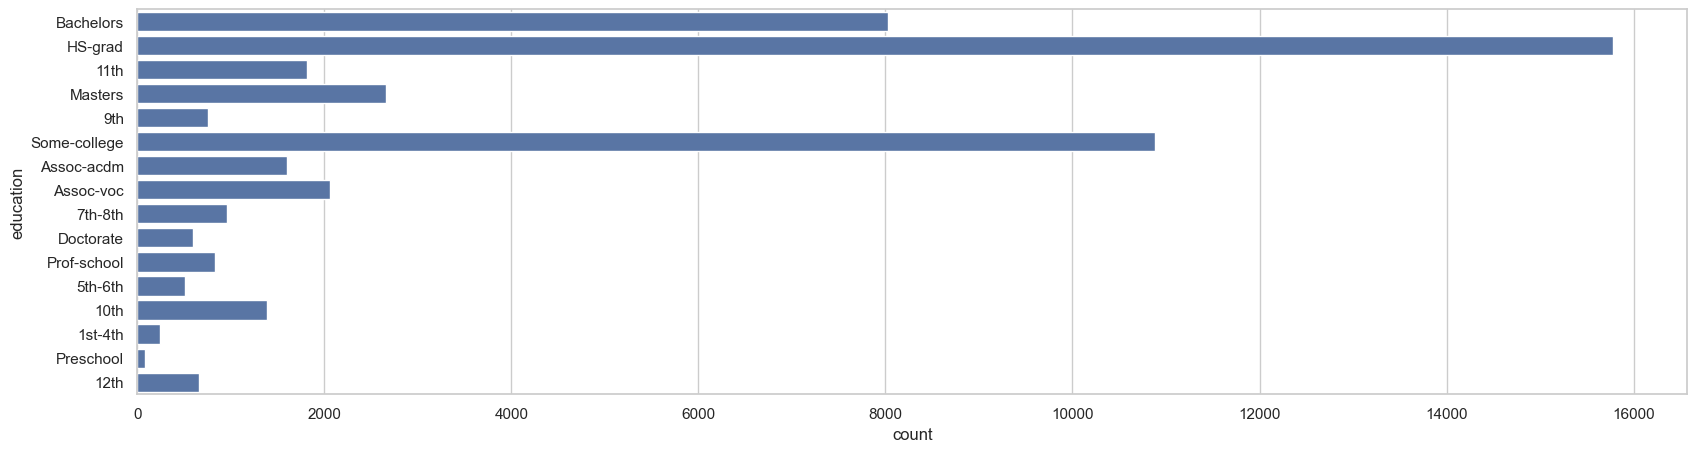

In [30]:
plt.figure(figsize=(20,5)) 
sns.countplot(y="education", data=dataset_raw);

In [31]:
dataset_raw.loc[dataset_raw['education'] == '10th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '11th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '12th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '1st-4th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '5th-6th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '7th-8th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '9th'           , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == 'Assoc-acdm'    , 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education'] == 'Assoc-voc'     , 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education'] == 'Bachelors'     , 'education'] = 'Bachelors'
dataset_raw.loc[dataset_raw['education'] == 'Doctorate'     , 'education'] = 'Doctorate'
dataset_raw.loc[dataset_raw['education'] == 'HS-Grad'       , 'education'] = 'HS-Graduate'
dataset_raw.loc[dataset_raw['education'] == 'Masters'       , 'education'] = 'Masters'
dataset_raw.loc[dataset_raw['education'] == 'Preschool'     , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == 'Prof-school'   , 'education'] = 'Professor'
dataset_raw.loc[dataset_raw['education'] == 'Some-college'  , 'education'] = 'HS-Graduate'

dataset_bin['education'] = dataset_raw['education']
dataset_con['education'] = dataset_raw['education']

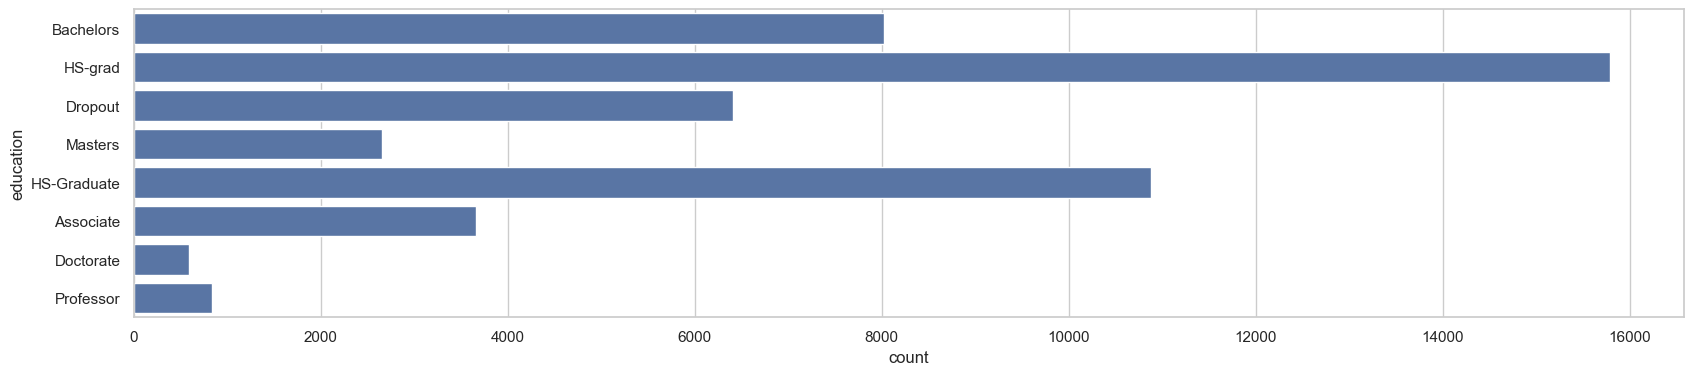

In [32]:
fig = plt.figure(figsize=(20,4)) 
sns.countplot(y="education", data=dataset_bin);

### Feature: Marital Status

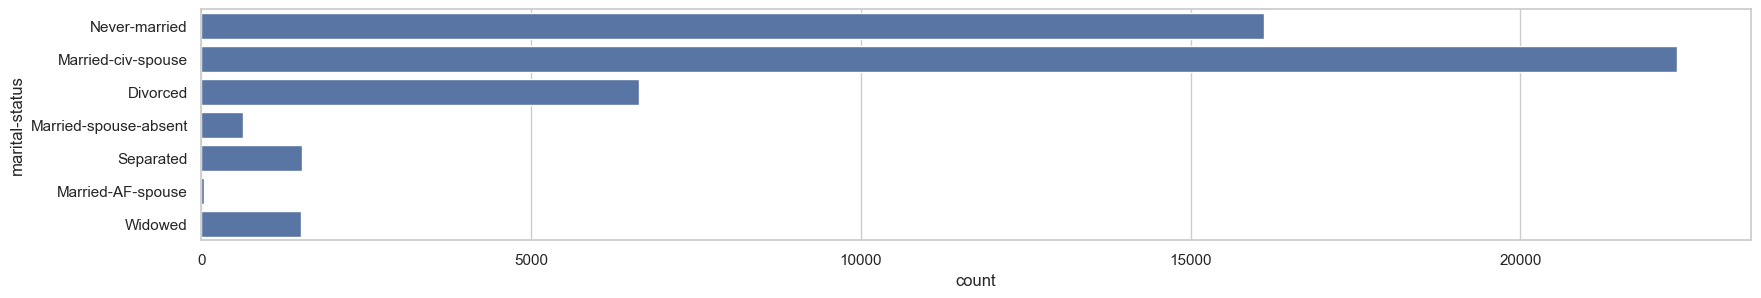

In [33]:
plt.figure(figsize=(20,3)) 
sns.countplot(y="marital-status", data=dataset_raw);

In [34]:
dataset_raw.loc[dataset_raw['marital-status'] == 'Never-married'        , 'marital-status'] = 'Never-Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-AF-spouse'    , 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-civ-spouse'   , 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-spouse-absent', 'marital-status'] = 'Not-Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Separated'            , 'marital-status'] = 'Separated'
dataset_raw.loc[dataset_raw['marital-status'] == 'Divorced'             , 'marital-status'] = 'Separated'
dataset_raw.loc[dataset_raw['marital-status'] == 'Widowed'              , 'marital-status'] = 'Widowed'

dataset_bin['marital-status'] = dataset_raw['marital-status']
dataset_con['marital-status'] = dataset_raw['marital-status']

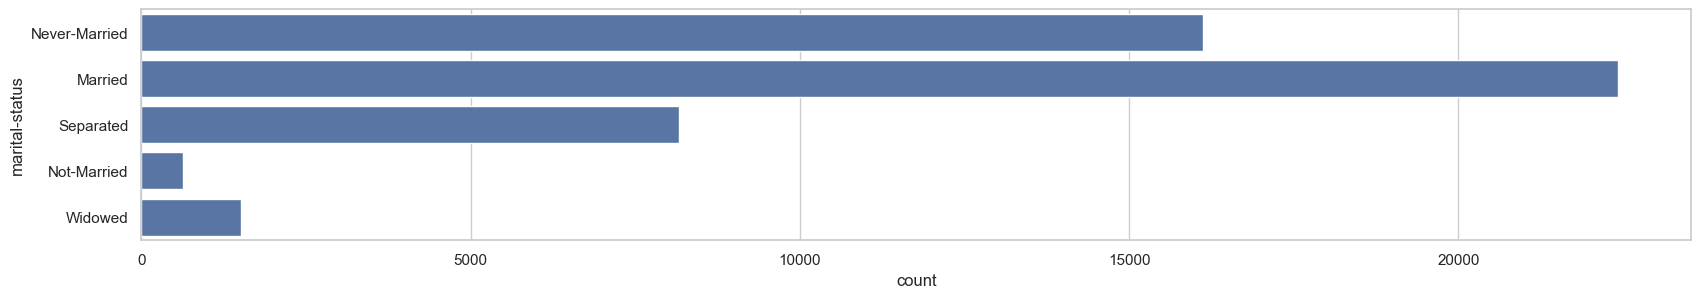

In [35]:
fig = plt.figure(figsize=(20,3)) 
sns.countplot(y="marital-status", data=dataset_bin);

### Feature: Final Weight

In [36]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
dataset_bin['fnlwgt'] = pd.cut(dataset_raw['fnlwgt'], 10)
dataset_con['fnlwgt'] = dataset_raw['fnlwgt']

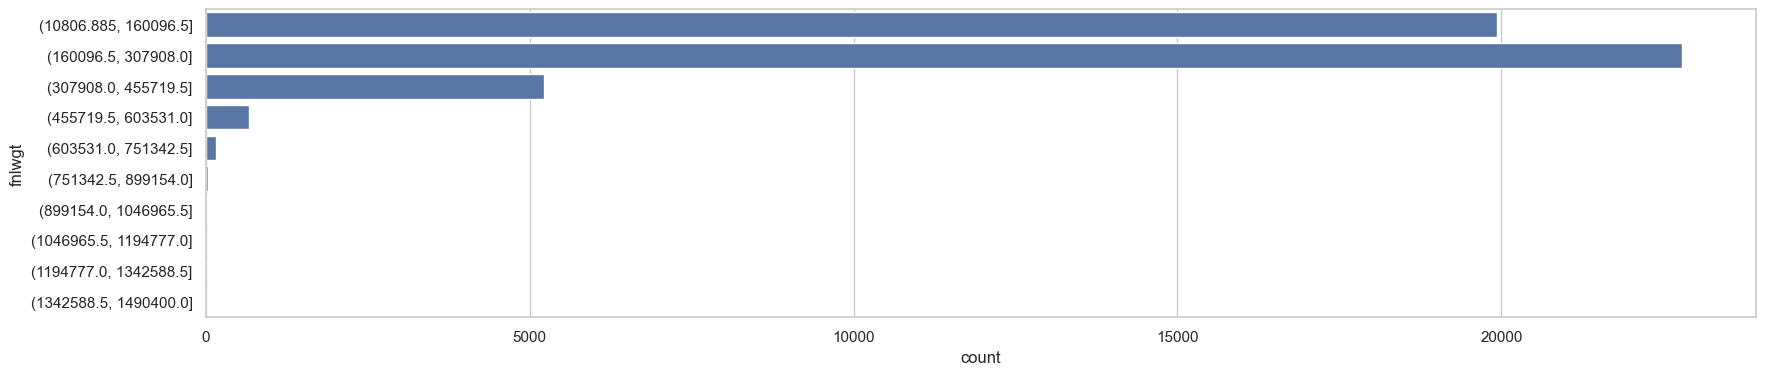

In [37]:
fig = plt.figure(figsize=(20,4)) 
sns.countplot(y="fnlwgt", data=dataset_bin);

### Feature: Education Number 

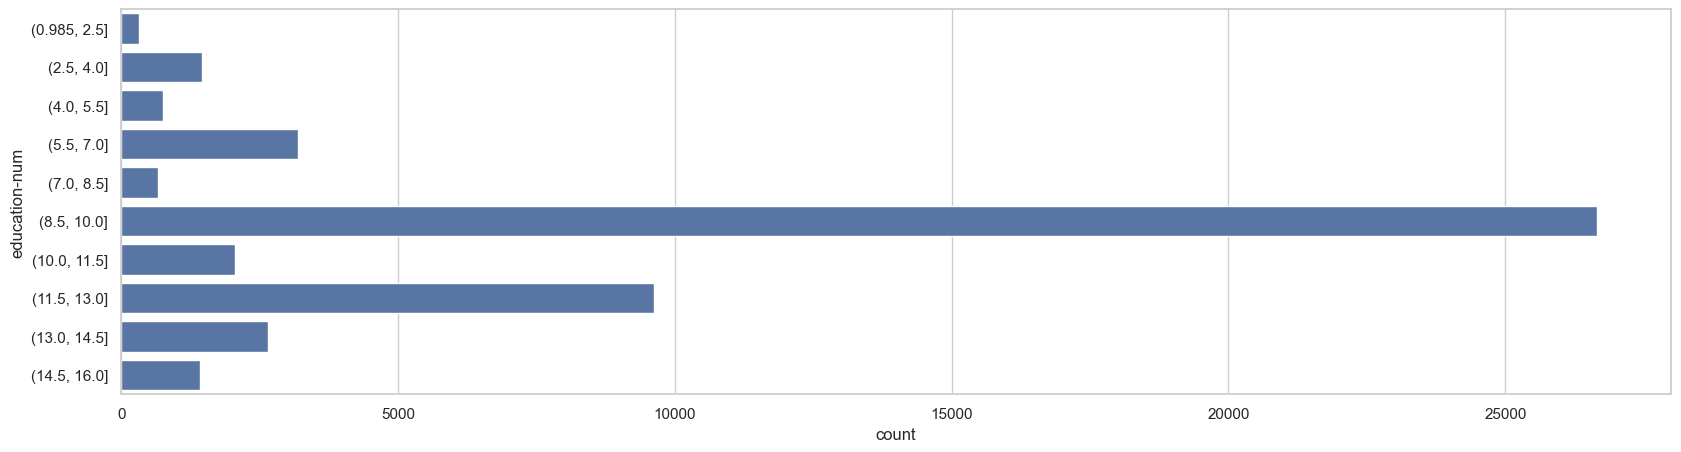

In [38]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
dataset_bin['education-num'] = pd.cut(dataset_raw['education-num'], 10)
dataset_con['education-num'] = dataset_raw['education-num']

fig = plt.figure(figsize=(20,5)) 
sns.countplot(y="education-num", data=dataset_bin);

### Feature: Hours per Week

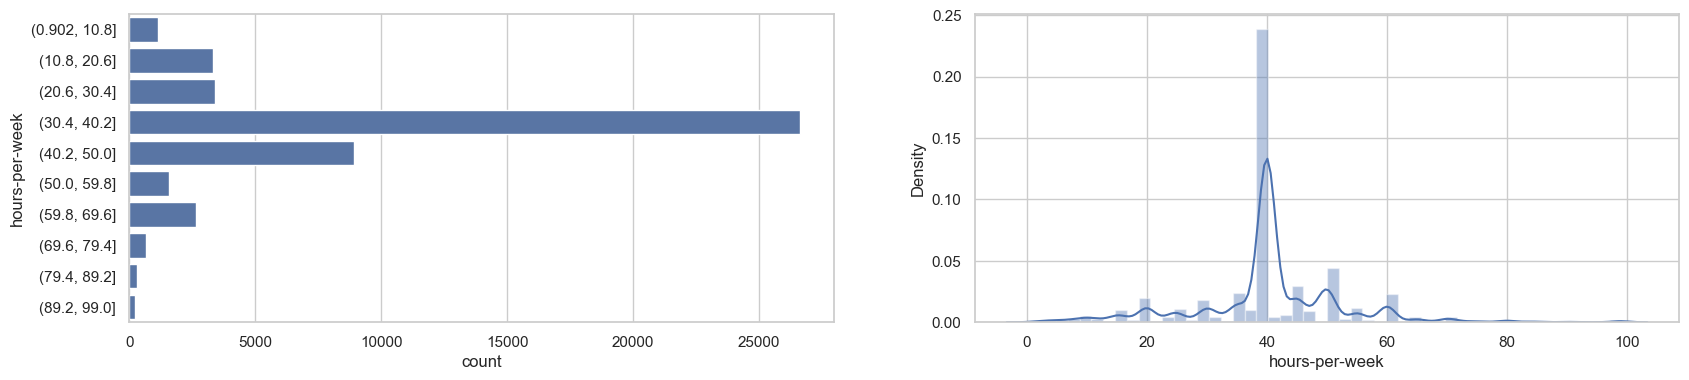

In [39]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
dataset_bin['hours-per-week'] = pd.cut(dataset_raw['hours-per-week'], 10)
dataset_con['hours-per-week'] = dataset_raw['hours-per-week']

fig = plt.figure(figsize=(20,4)) 
plt.subplot(1, 2, 1)
sns.countplot(y="hours-per-week", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['hours-per-week']);

### Feature: Captial Gain

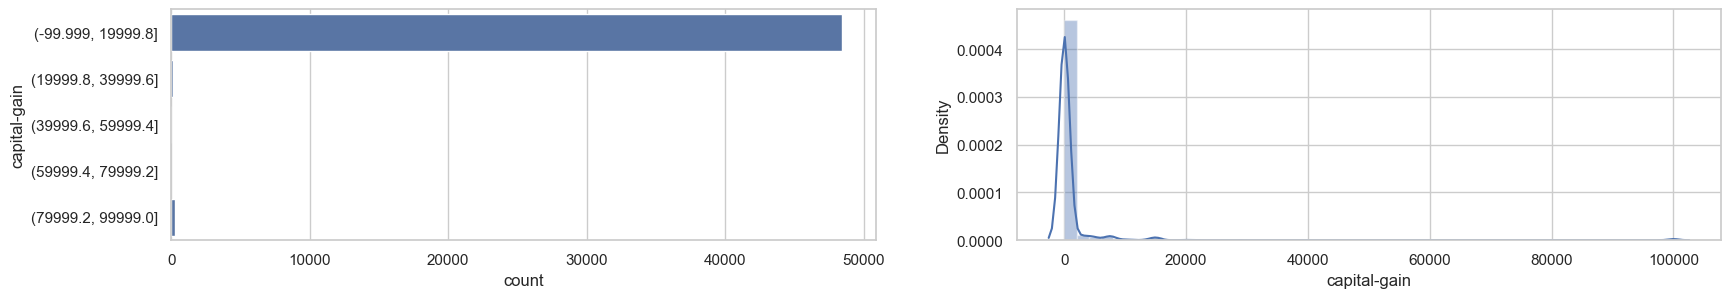

In [40]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
dataset_bin['capital-gain'] = pd.cut(dataset_raw['capital-gain'], 5)
dataset_con['capital-gain'] = dataset_raw['capital-gain']

fig = plt.figure(figsize=(20,3)) 
plt.subplot(1, 2, 1)
sns.countplot(y="capital-gain", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-gain']);

### Feature: Capital loss

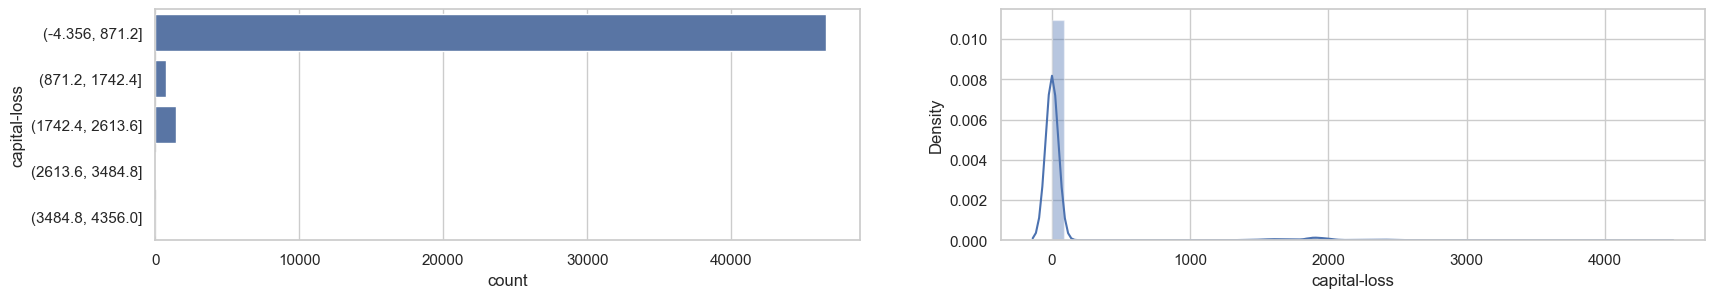

In [41]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
dataset_bin['capital-loss'] = pd.cut(dataset_raw['capital-loss'], 5)
dataset_con['capital-loss'] = dataset_raw['capital-loss']

fig = plt.figure(figsize=(20,3)) 
plt.subplot(1, 2, 1)
sns.countplot(y="capital-loss", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-loss']);

### Features: Race, Sex, Relationships

In [42]:
# Some features we'll consider to be in good enough shape as to pass through
dataset_con['sex'] = dataset_bin['sex'] = dataset_raw['sex']
dataset_con['race'] = dataset_bin['race'] = dataset_raw['race']
dataset_con['relationship'] = dataset_bin['relationship'] = dataset_raw['relationship']

## Bi-variate Analysis

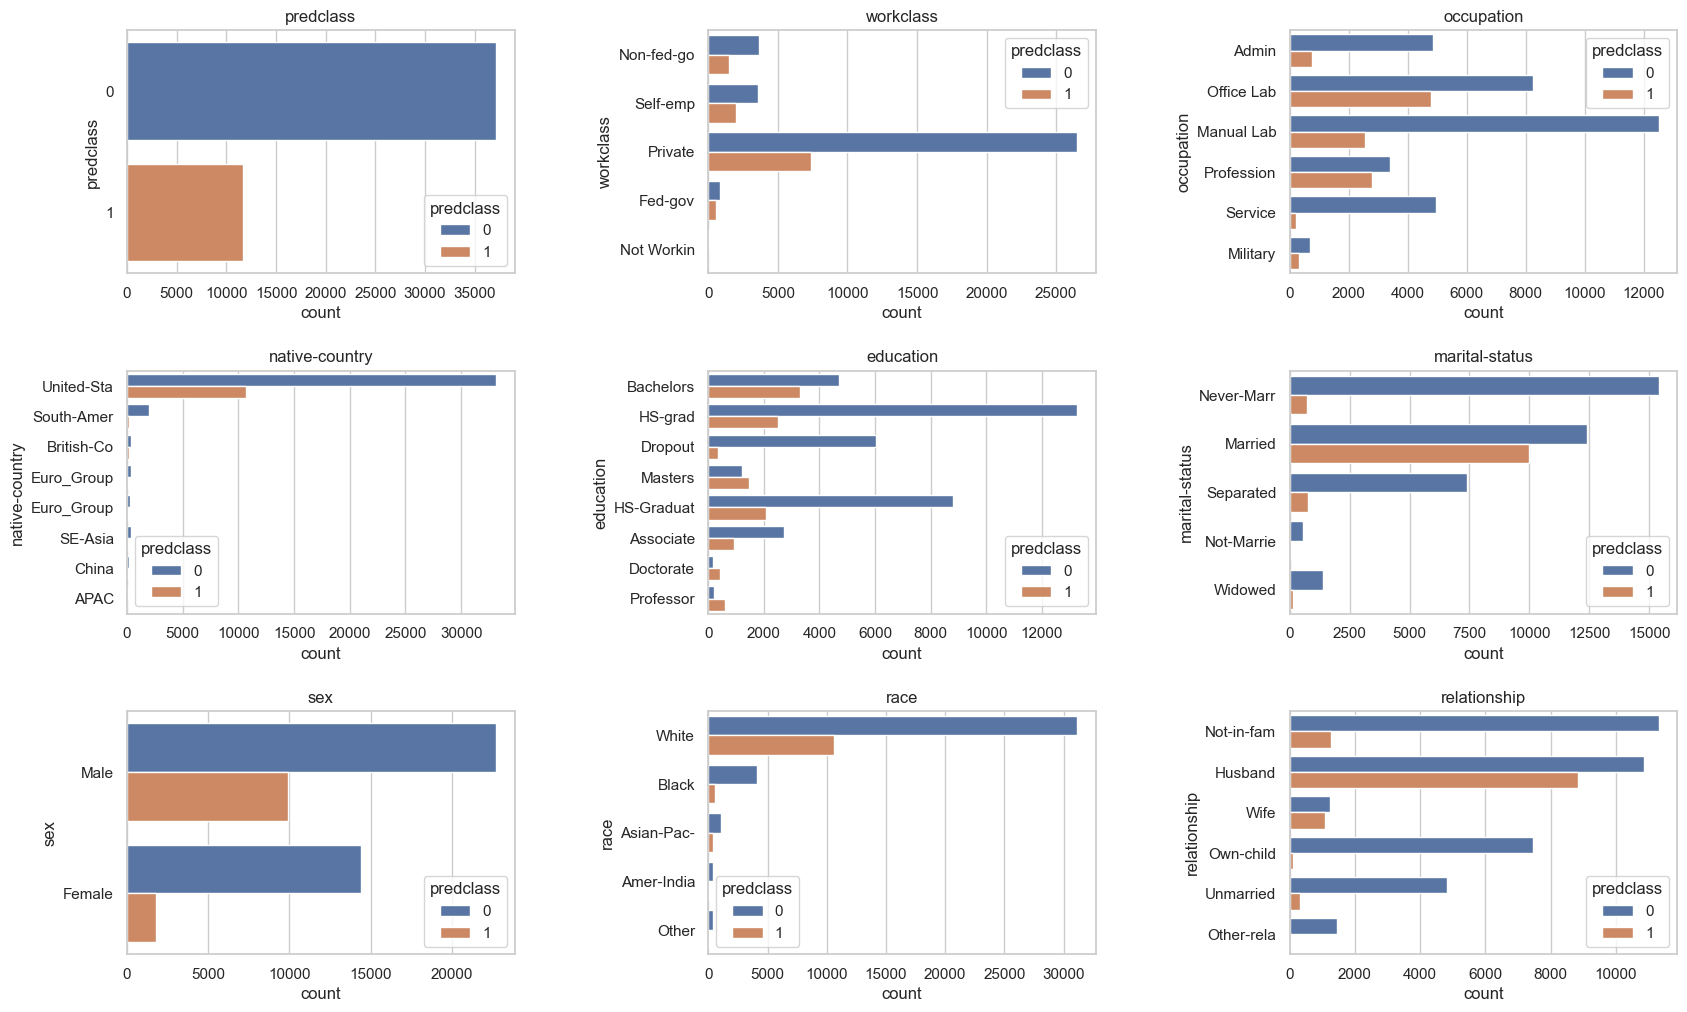

In [43]:
# Plot a count of the categories from each categorical feature split by our prediction class: salary - predclass.
def plot_bivariate_bar(dataset, hue, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    dataset = dataset.select_dtypes(include=[object])
    
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == object:
            g = sns.countplot(y=column, hue=hue, data=dataset)
            substrings = [s.get_text()[:10] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            
plot_bivariate_bar(dataset_con, hue='predclass', cols=3, width=20, height=12, hspace=0.4, wspace=0.5)

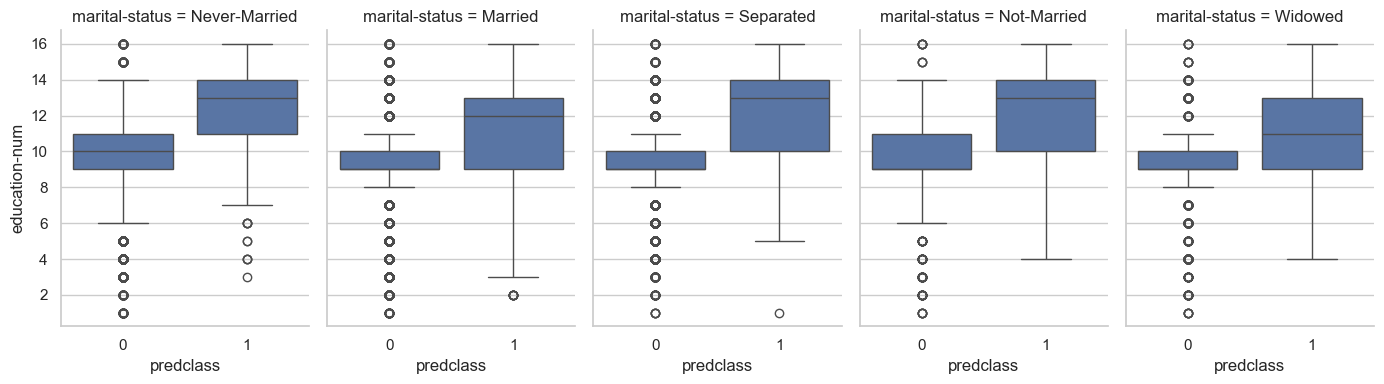

In [44]:
# Effect of Marital Status and Education on Income, across Marital Status.

# Ensure 'predclass_order' matches the unique values in 'predclass' column of your DataFrame
predclass_order = dataset_con['predclass'].unique().tolist()  # Example adjustment

g = sns.FacetGrid(dataset_con, col='marital-status', height=4, aspect=.7)
g.map_dataframe(sns.boxplot, x='predclass', y='education-num', order=predclass_order)
plt.show()


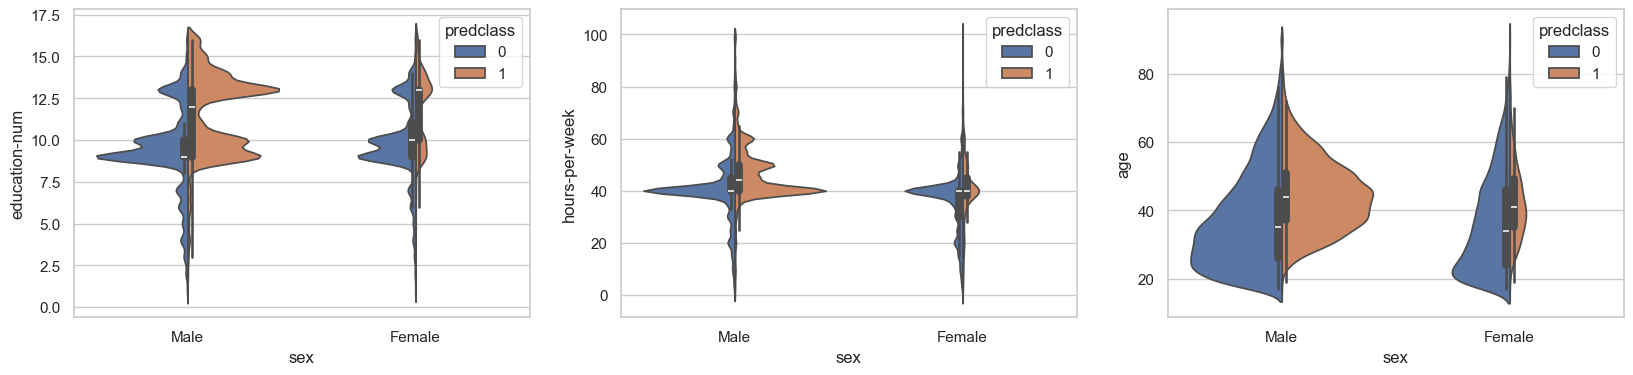

In [45]:
# Historical Trends on the Sex, Education, HPW and Age impact on Income.
fig = plt.figure(figsize=(20,4)) 
plt.subplot(1, 3, 1)
sns.violinplot(x='sex', y='education-num', hue='predclass', data=dataset_con, split=True, scale='count');

plt.subplot(1, 3, 2)
sns.violinplot(x='sex', y='hours-per-week', hue='predclass', data=dataset_con, split=True, scale='count');

plt.subplot(1, 3, 3)
sns.violinplot(x='sex', y='age', hue='predclass', data=dataset_con, split=True, scale='count');


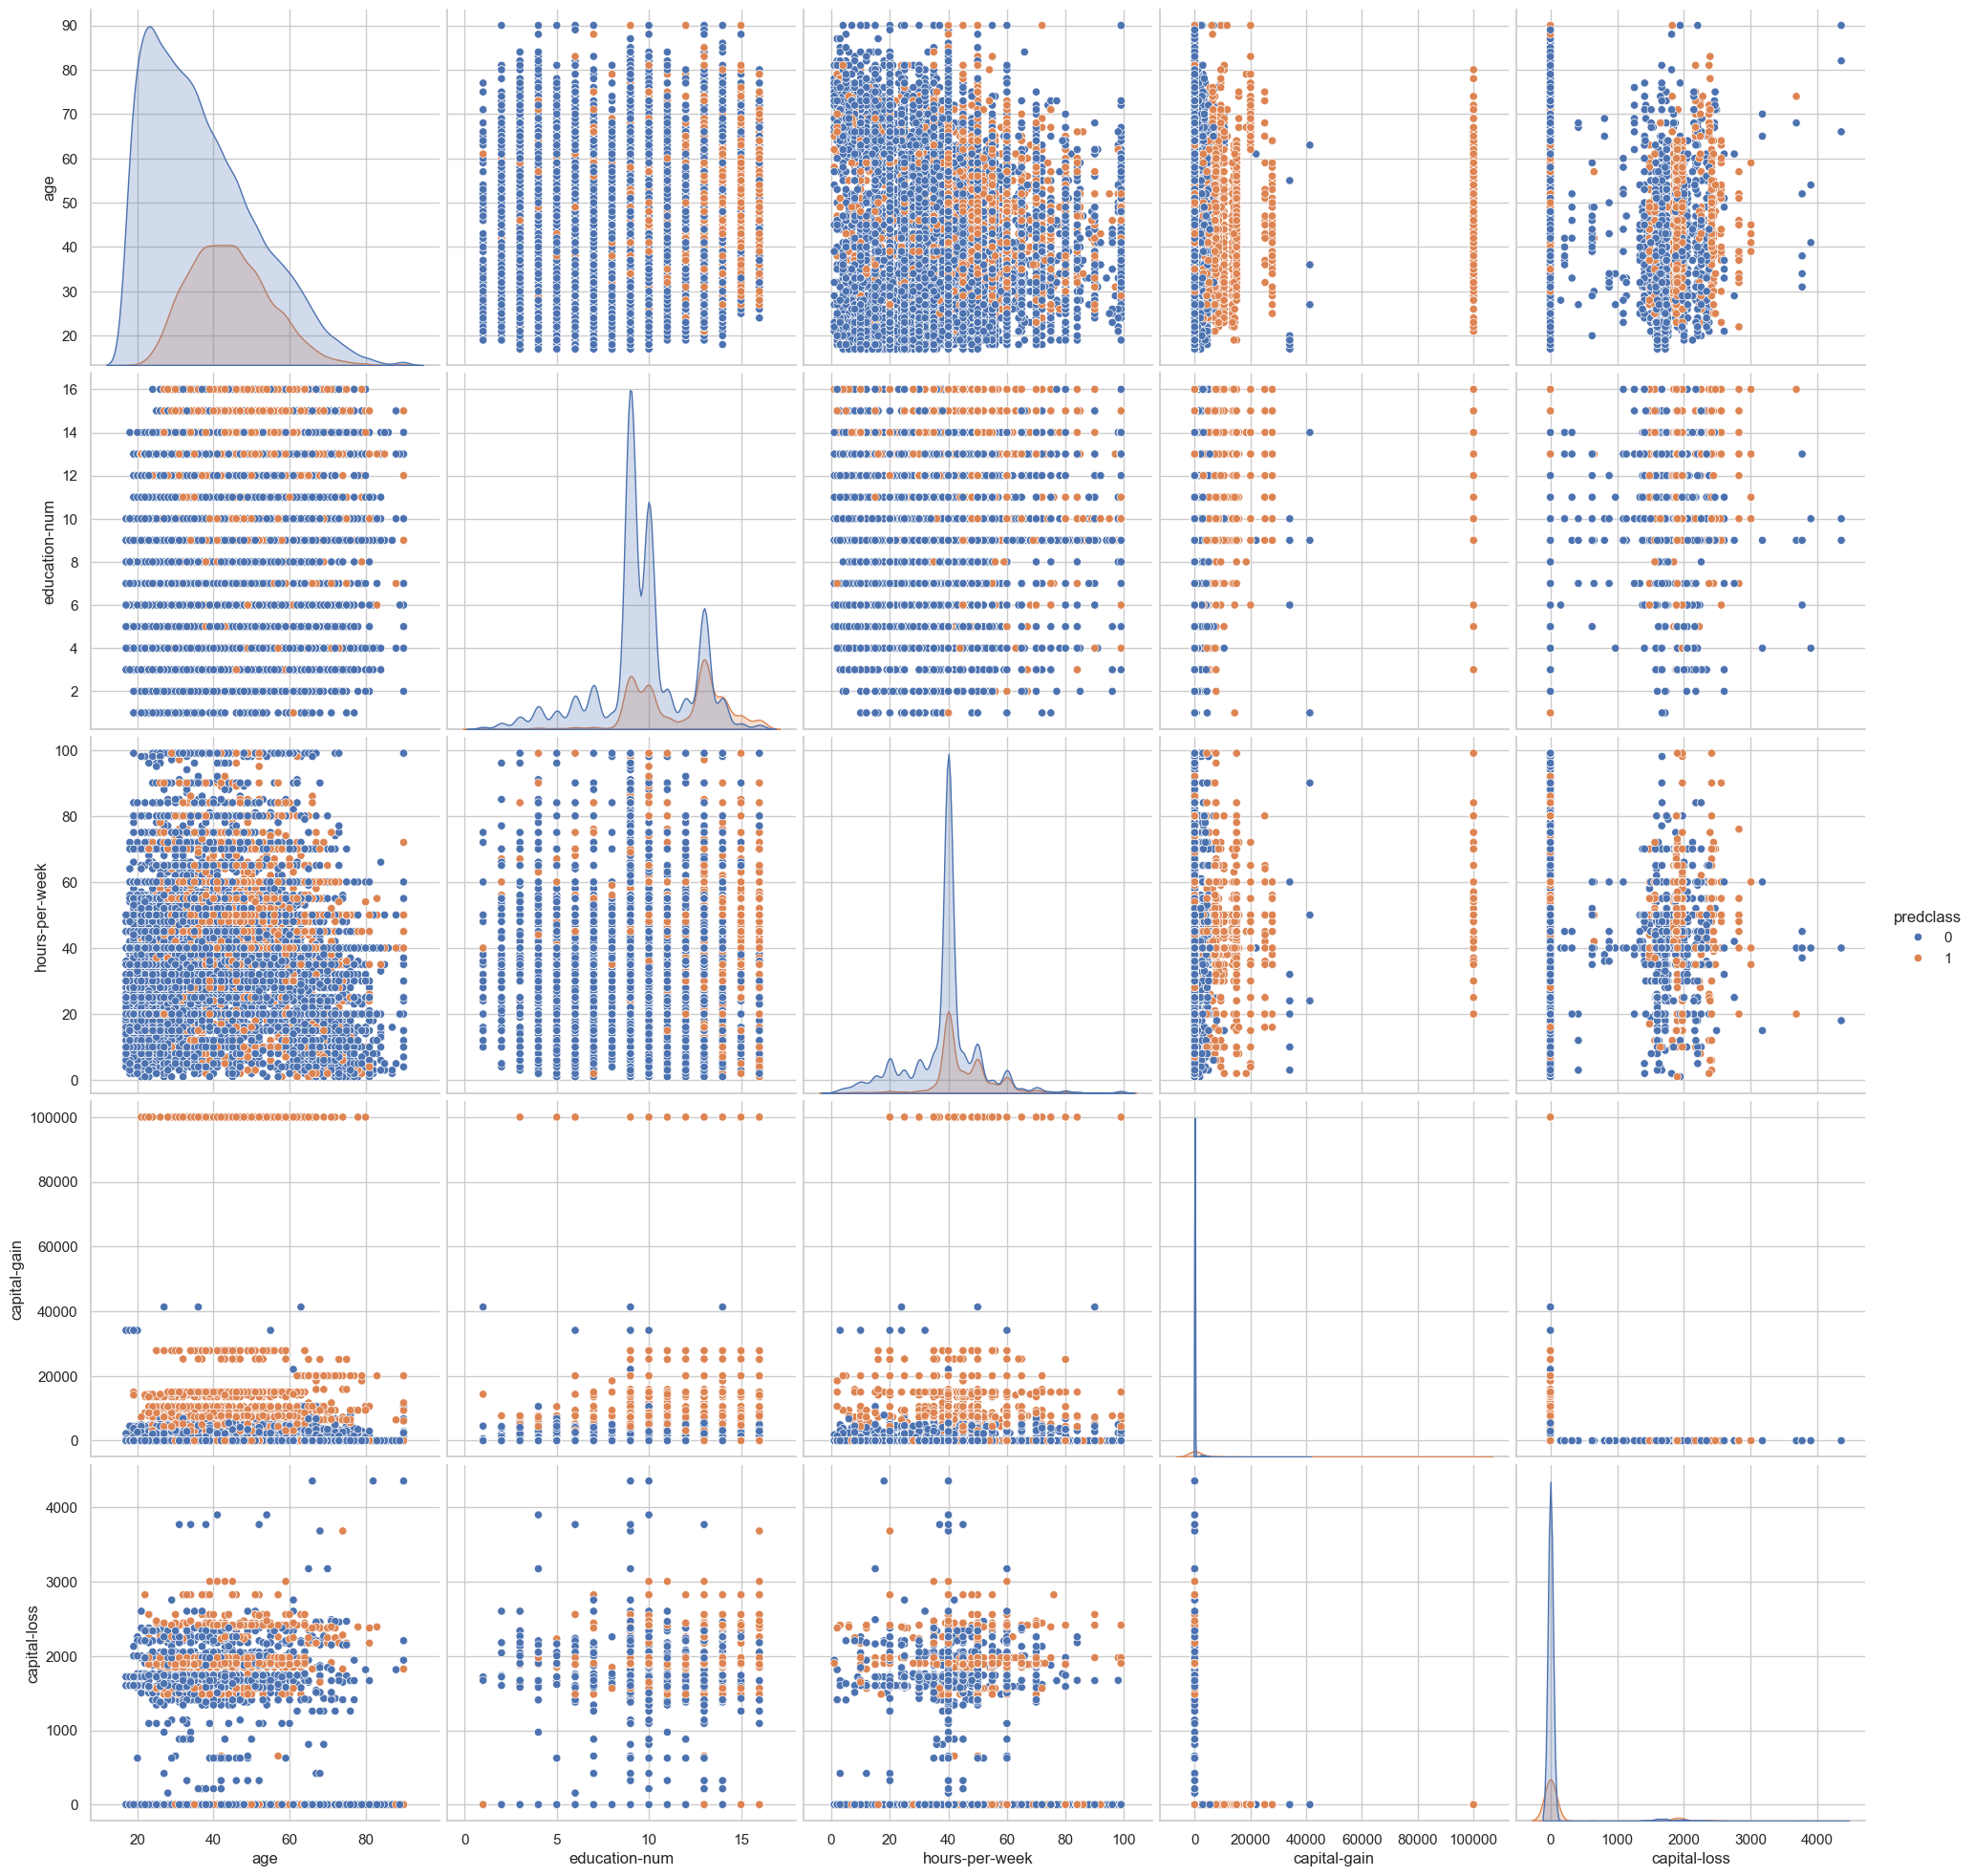

In [46]:
# Interaction between pairs of features.
sns.pairplot(dataset_con[['age','education-num','hours-per-week','predclass','capital-gain','capital-loss']], 
             hue="predclass", 
             diag_kind="kde",
             size=4);

## Feature Crossing: Age + Hours per Week

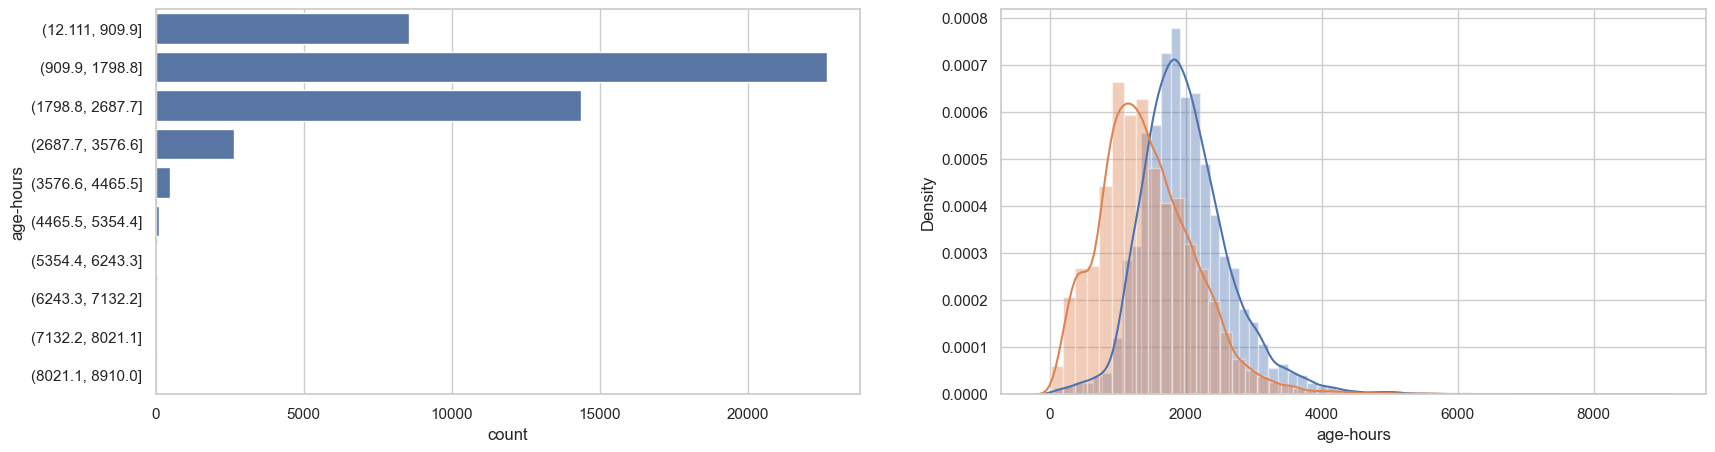

In [47]:
# Crossing Numerical Features
dataset_con['age-hours'] = dataset_con['age'] * dataset_con['hours-per-week']

dataset_bin['age-hours'] = pd.cut(dataset_con['age-hours'], 10)
dataset_con['age-hours'] = dataset_con['age-hours']

fig = plt.figure(figsize=(20,5)) 
plt.subplot(1, 2, 1)
sns.countplot(y="age-hours", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 1]['age-hours'], kde_kws={"label": ">$50K"});
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 0]['age-hours'], kde_kws={"label": "<$50K"});


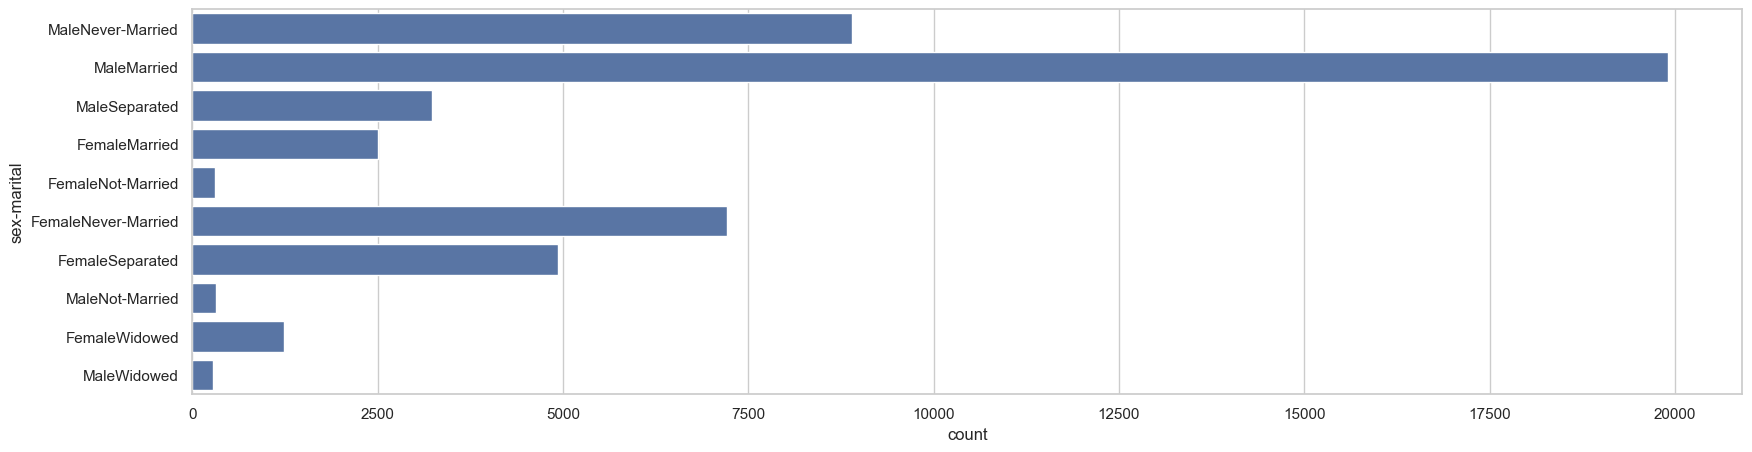

In [48]:
# Crossing Categorical Features
dataset_bin['sex-marital'] = dataset_con['sex-marital'] = dataset_con['sex'] + dataset_con['marital-status']

fig = plt.figure(figsize=(20,5)) 
sns.countplot(y="sex-marital", data=dataset_bin);

## Feature Encoding: 

In [49]:
# One Hot Encodes all labels before Machine Learning
one_hot_cols = dataset_bin.columns.tolist()
one_hot_cols.remove('predclass')
dataset_bin_enc = pd.get_dummies(dataset_bin, columns=one_hot_cols)

dataset_bin_enc.head()

predclass  age_(16.927, 24.3]  age_(24.3, 31.6]  age_(31.6, 38.9]  \
0         0               False             False             False   
1         0               False             False             False   
2         0               False             False              True   
3         0               False             False             False   
4         0               False              True             False   

   age_(38.9, 46.2]  age_(46.2, 53.5]  age_(53.5, 60.8]  age_(60.8, 68.1]  \
0              True             False             False             False   
1             False              True             False             False   
2             False             False             False             False   
3             False              True             False             False   
4             False             False             False             False   

   age_(68.1, 75.4]  age_(75.4, 82.7]  ...  sex-marital_FemaleMarried  \
0             False             False  ...                      False   
1             False             False  ...                      False   
2             False             False  ...                      False   
3             False             False  ...                      False   
4             False             False  ...                       True   

   sex-marital_FemaleNever-Married  sex-marital_FemaleNot-Married  \
0                            False                          False   
1                            False                          False   
2                            False                          False   
3                            False                          False   
4                            False                          False   

   sex-marital_FemaleSeparated  sex-marital_FemaleWidowed  \
0                        False                      False   
1                        False                      False   
2                        False                      False   
3                        False                      False   
4                        False                      False   

   sex-marital_MaleMarried  sex-marital_MaleNever-Married  \
0                    False                           True   
1                     True                          False   
2                    False                          False   
3                     True                          False   
4                    False                          False   

   sex-marital_MaleNot-Married  sex-marital_MaleSeparated  \
0                        False                      False   
1                        False                      False   
2                        False                       True   
3                        False                      False   
4                        False                      False   

   sex-marital_MaleWidowed  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  

[5 rows x 116 columns]

In [50]:
# Label Encode all labels
dataset_con_enc = dataset_con.apply(LabelEncoder().fit_transform)

#dataset_con_enc.head()

In [51]:
dataset_con_enc.head()

predclass  age  workclass  occupation  native-country  education  \
0          0   22          1           0               7          1   
1          0   33          4           3               7          1   
2          0   21          3           1               7          5   
3          0   36          3           1               7          3   
4          0   11          3           4               6          1   

   marital-status  fnlwgt  education-num  hours-per-week  capital-gain  \
0               1    3461             12              39            27   
1               0    3788             12              12             0   
2               3   18342              8              39             0   
3               0   19995              6              39             0   
4               0   25405             12              39             0   

   capital-loss  sex  race  relationship  age-hours  sex-marital  
0             0    1     4             1        695            6  
1             0    1     4             0        334            5  
2             0    1     4             1        683            8  
3             0    1     2             0        890            5  
4             0    0     2             5        530            0

## Feature reduciton + selection

Dimensionality reduction:
- PCA
- SVD 

Feature importance/relevance: 
- Filter methods 
- Wrapper methods
- Embedded methods

### Feature Correlation

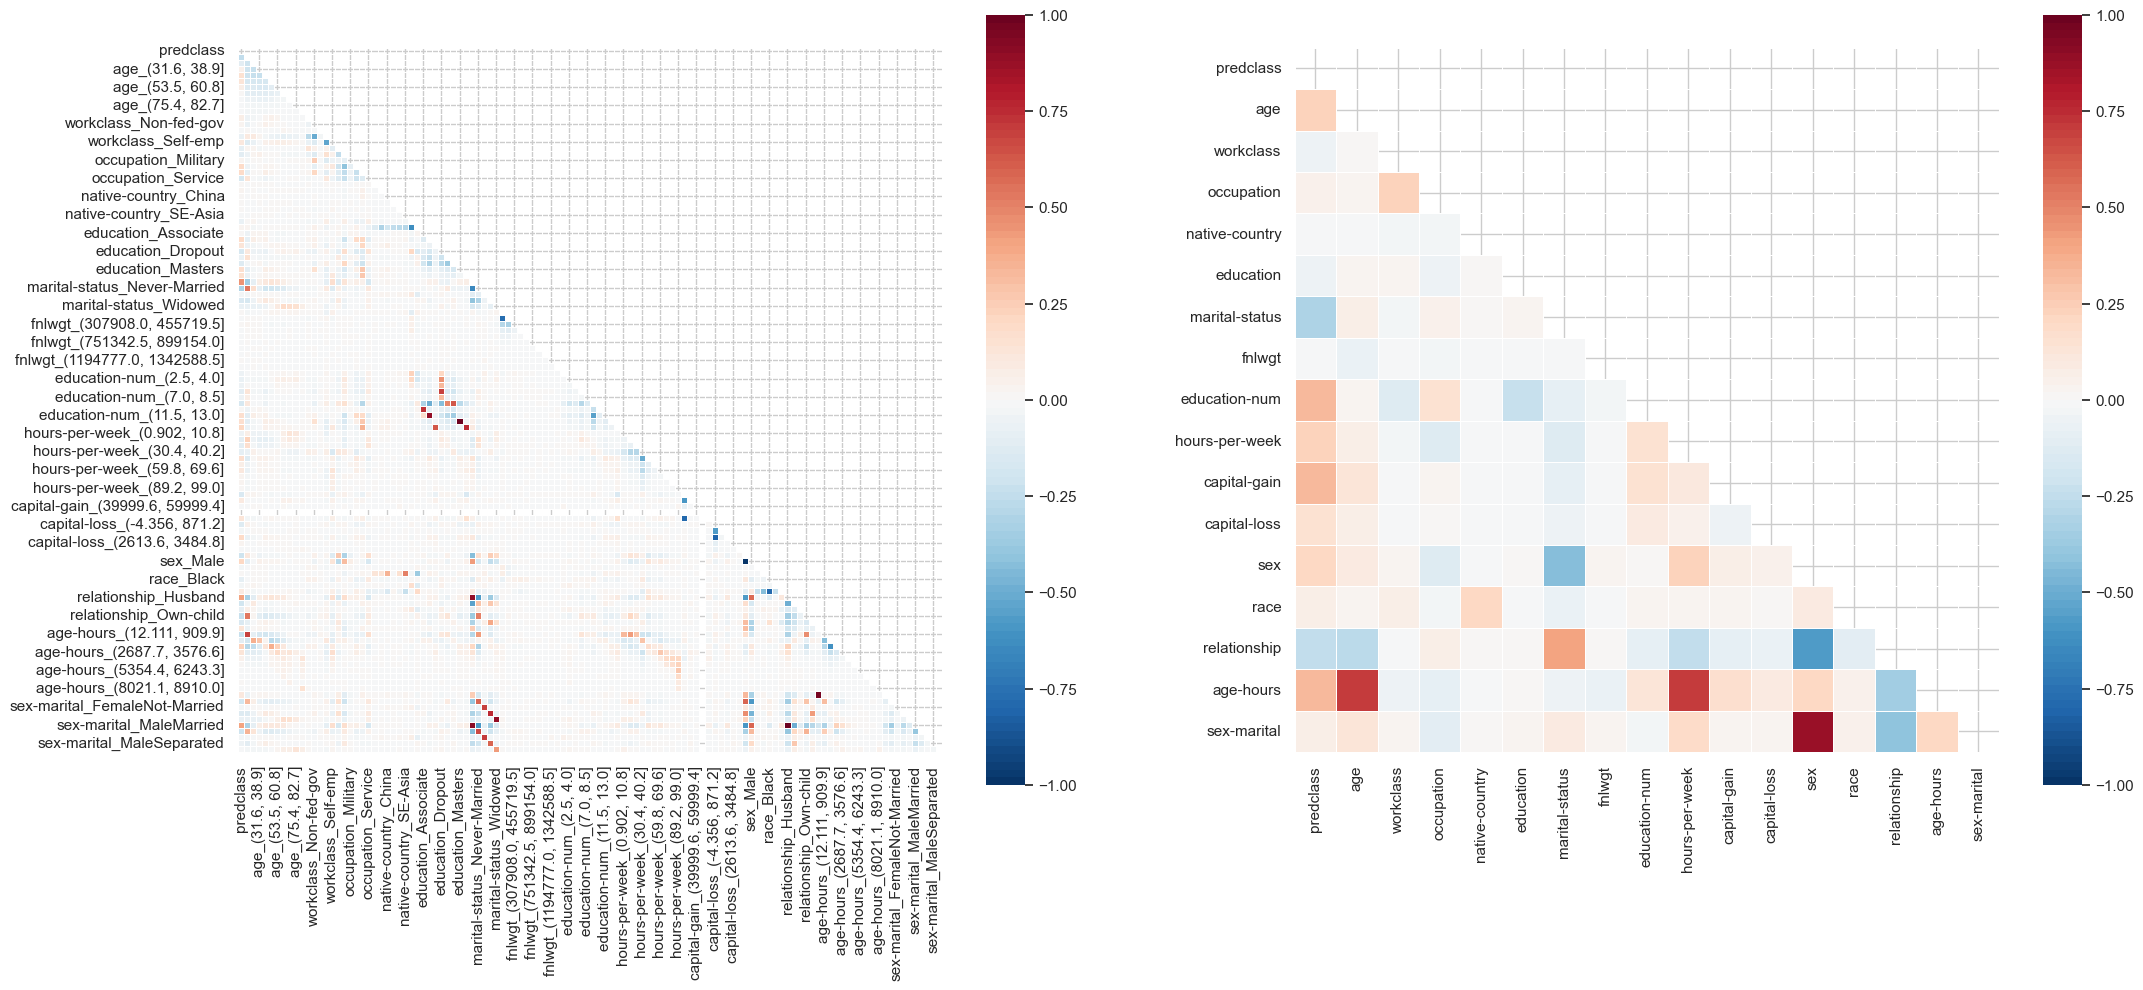

In [52]:
# Create a correlation plot of both datasets.
fig = plt.figure(figsize=(25,10)) 

plt.subplot(1, 2, 1)
# Generate a mask for the upper triangle
mask = np.zeros_like(dataset_bin_enc.corr(), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_bin_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

plt.subplot(1, 2, 2)
mask = np.zeros_like(dataset_con_enc.corr(), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_con_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);



### Feature Importance

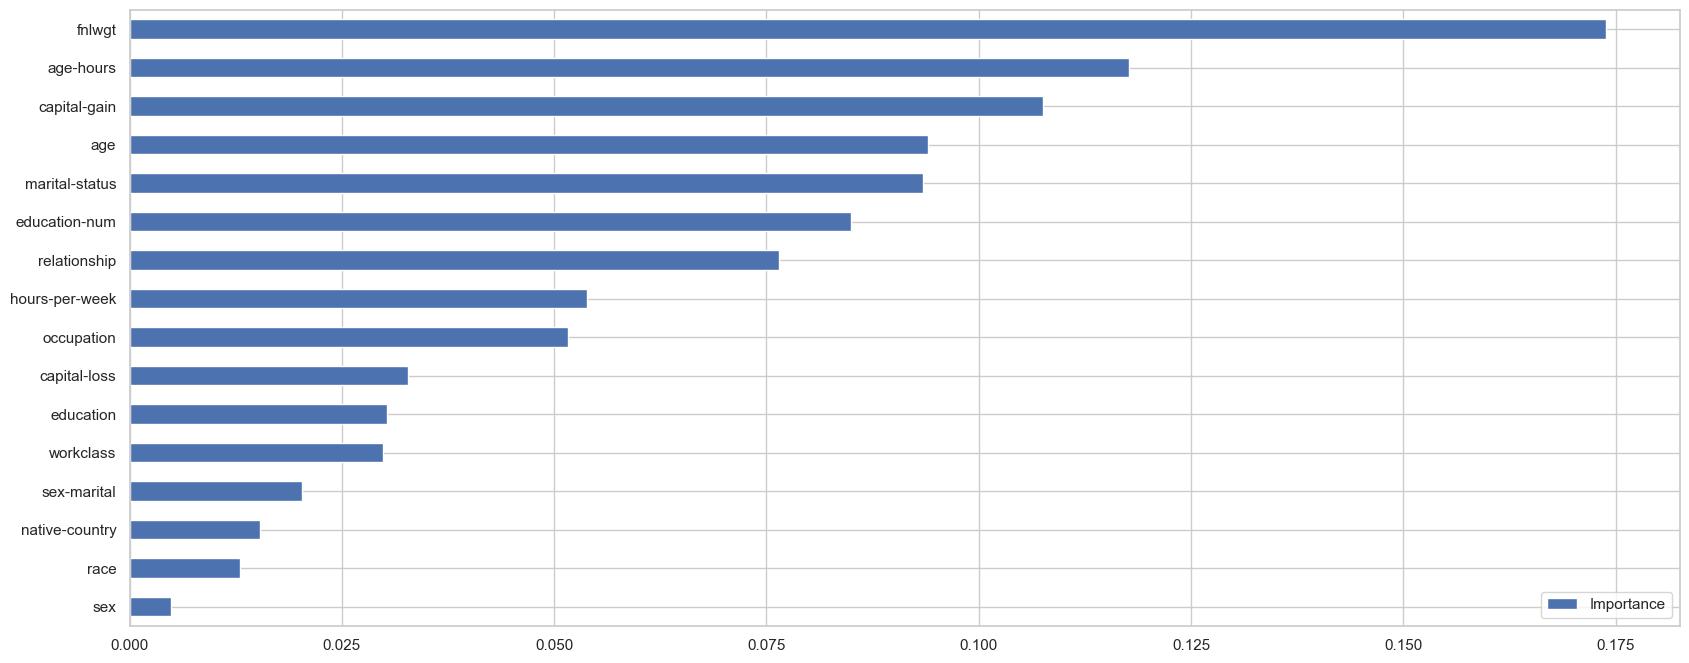

In [53]:
# Using Random Forest to gain an insight on Feature Importance
clf = RandomForestClassifier()
clf.fit(dataset_con_enc.drop('predclass', axis=1), dataset_con_enc['predclass'])

importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=dataset_con_enc.drop('predclass', axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

### PCA

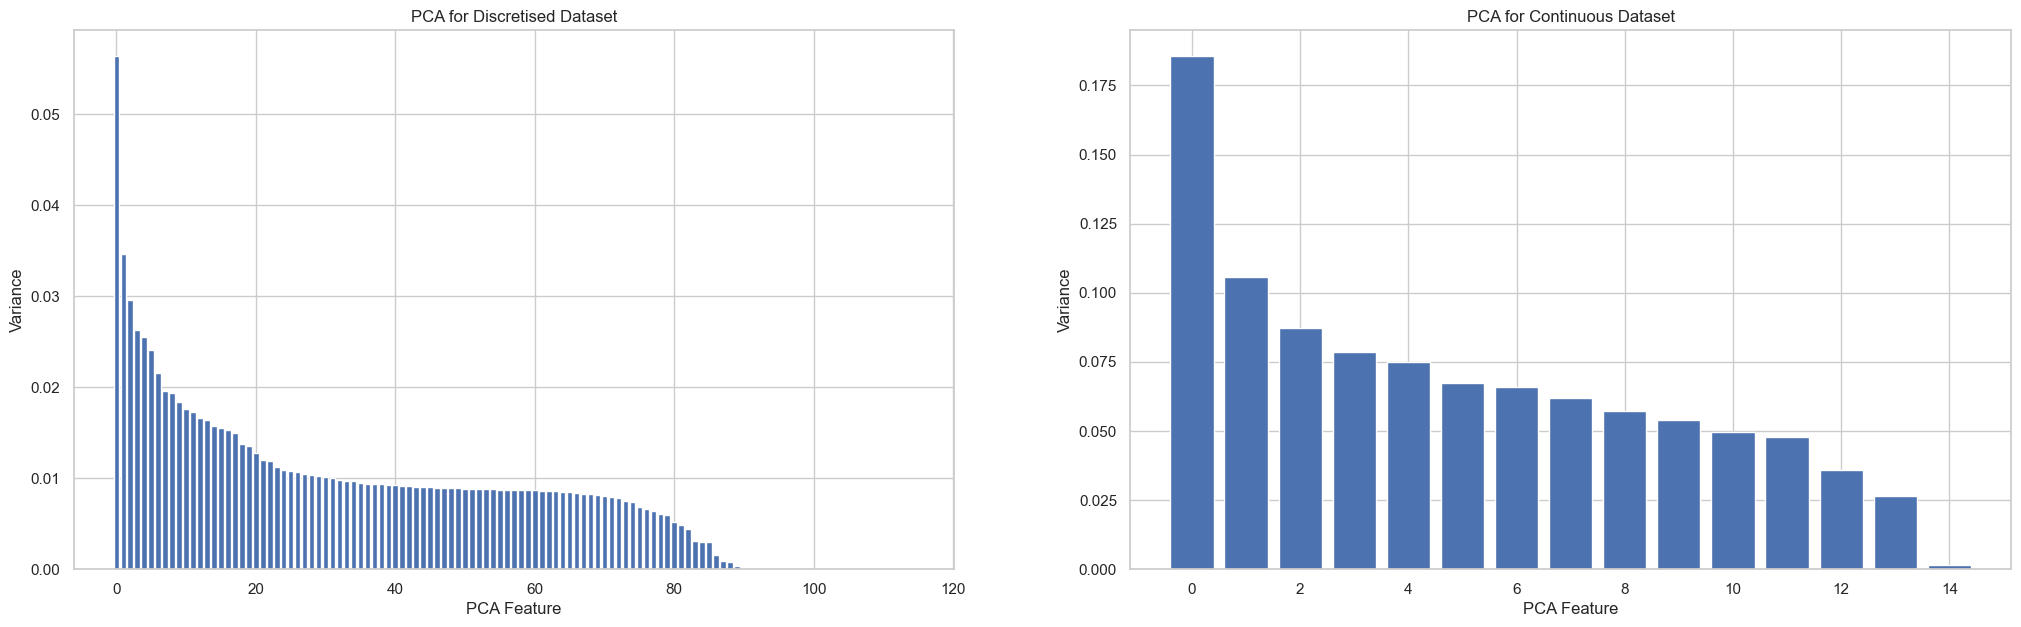

In [54]:
# Calculating PCA for both datasets, and graphing the Variance for each feature, per dataset
std_scale = preprocessing.StandardScaler().fit(dataset_bin_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_bin_enc.drop('predclass', axis=1))
pca1 = PCA(n_components=len(dataset_bin_enc.columns)-1)
fit1 = pca1.fit(X)

std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_con_enc.drop('predclass', axis=1))
pca2 = PCA(n_components=len(dataset_con_enc.columns)-2)
fit2 = pca2.fit(X)

# Graphing the variance per feature
plt.figure(figsize=(25,7)) 

plt.subplot(1, 2, 1)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Discretised Dataset')
plt.bar(range(0, fit1.explained_variance_ratio_.size), fit1.explained_variance_ratio_);

plt.subplot(1, 2, 2)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Continuous Dataset')
plt.bar(range(0, fit2.explained_variance_ratio_.size), fit2.explained_variance_ratio_);

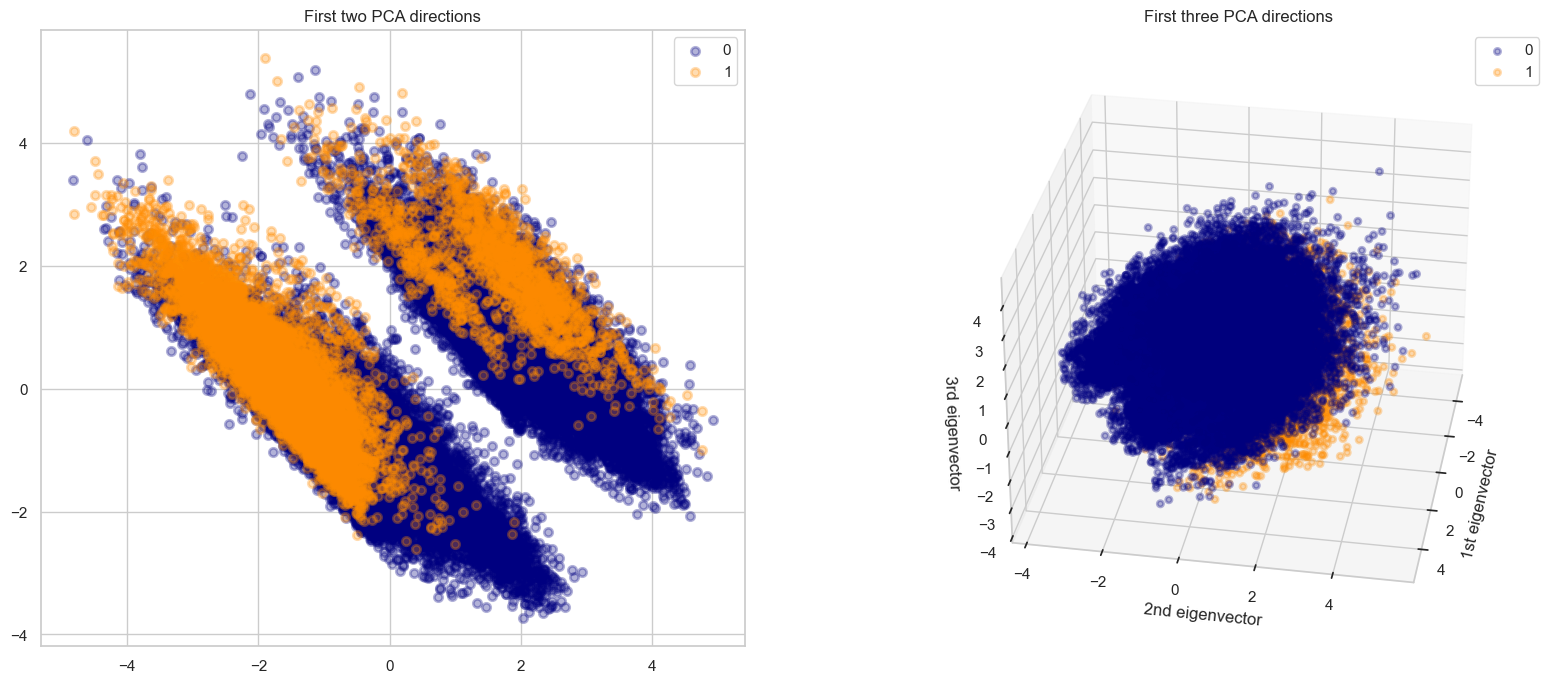

In [55]:
# PCA's components graphed in 2D and 3D
# Apply Scaling 
std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_con_enc.drop('predclass', axis=1))
y = dataset_con_enc['predclass']

# Formatting
target_names = [0,1]
colors = ['navy','darkorange']
lw = 2
alpha = 0.3
# 2 Components PCA
plt.figure(2, figsize=(20, 8))

plt.subplot(1, 2, 1)
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], 
                color=color, 
                alpha=alpha, 
                lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('First two PCA directions');

# 3 Components PCA
ax = plt.subplot(1, 2, 2, projection='3d')

pca = PCA(n_components=3)
X_reduced = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2], 
               color=color,
               alpha=alpha,
               lw=lw, 
               label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# rotate the axes
ax.view_init(30, 10)

### Recursibe Feature Elimination

/Users/klemens.floege/Desktop/Dev/meta-learning-synthetic-data/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/klemens.floege/Desktop/Dev/meta-learning-synthetic-data/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Feature Ranking For Non-Discretised: [1 1 4 1 1 1 5 1 2 1 1 1 1 1 3 1]
Optimal number of features : 12


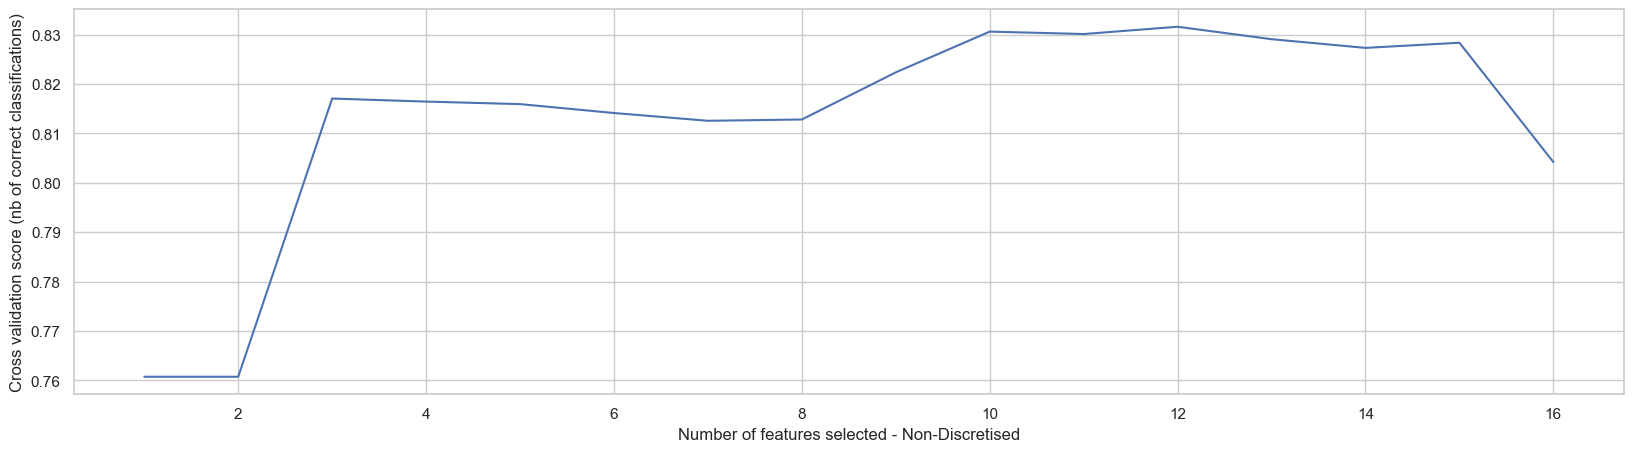

In [56]:
# Calculating RFE for non-discretised dataset, and graphing the Importance for each feature, per dataset
selector1 = RFECV(LogisticRegression(), step=1, cv=5, n_jobs=-1)
selector1 = selector1.fit(dataset_con_enc.drop('predclass', axis=1).values, dataset_con_enc['predclass'].values)
print("Feature Ranking For Non-Discretised: %s" % selector1.ranking_)
print("Optimal number of features : %d" % selector1.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20,5)) 
plt.xlabel("Number of features selected - Non-Discretised")
plt.ylabel("Cross validation score (nb of correct classifications)")

#plt.plot(range(1, len(selector1.grid_scores_) + 1), selector1.grid_scores_);
plt.plot(range(1, len(selector1.cv_results_['mean_test_score']) + 1), selector1.cv_results_['mean_test_score']);


# Feature space could be subsetted like so:
dataset_con_enc = dataset_con_enc[dataset_con_enc.columns[np.insert(selector1.support_, 0, True)]]

Feature Ranking For Non-Discretised: [ 2  5  9  8  1  1  1  3  4  7 10  6]
Optimal number of features : 3


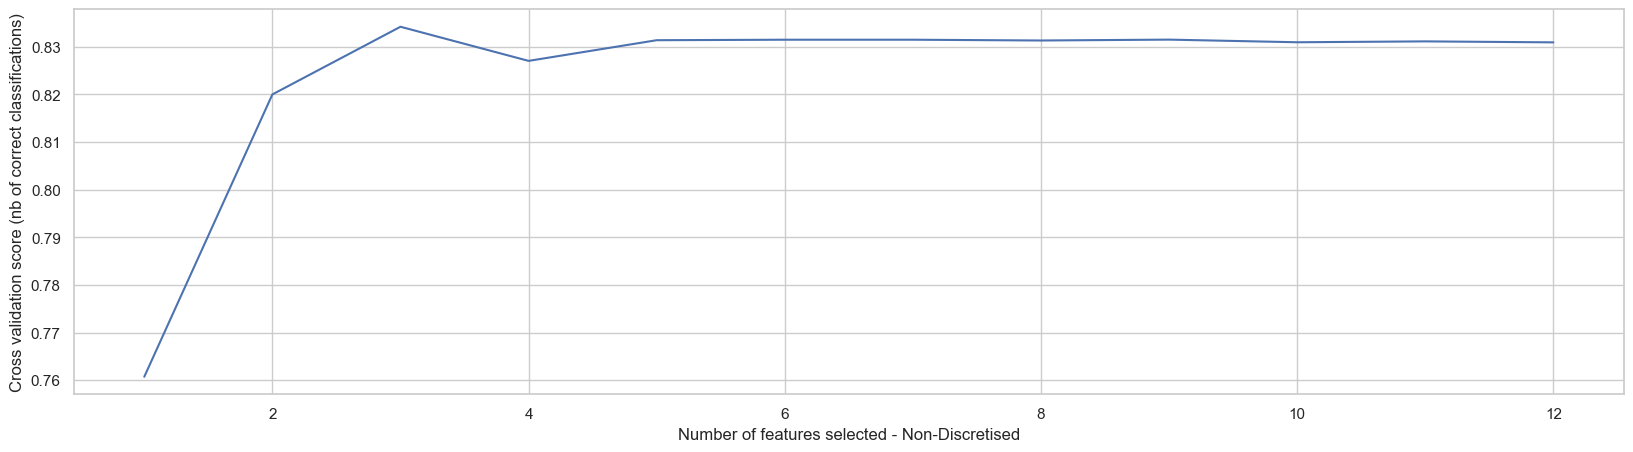

In [57]:
# Not sur while this yields different results


from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Assuming dataset_con_enc is your dataset

# Define your pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression(max_iter=1000))  # Increase the max_iter
])

# Specify the importance_getter to access 'logreg' step's 'coef_' attribute
selector1 = RFECV(estimator=pipeline, step=1, cv=5, n_jobs=-1, scoring='accuracy',
                  importance_getter='named_steps.logreg.coef_')

dataset_con_enc_features = dataset_con_enc.drop('predclass', axis=1)
dataset_con_enc_target = dataset_con_enc['predclass']

# Fit RFECV
selector1 = selector1.fit(dataset_con_enc_features, dataset_con_enc_target)

print("Feature Ranking For Non-Discretised: %s" % selector1.ranking_)
print("Optimal number of features : %d" % selector1.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20,5))
plt.xlabel("Number of features selected - Non-Discretised")
plt.ylabel("Cross validation score (nb of correct classifications)")

plt.plot(range(1, len(selector1.cv_results_['mean_test_score']) + 1), selector1.cv_results_['mean_test_score'])
plt.show()

## Selecting Dataset

In [58]:
# OPTIONS: 
# - dataset_bin_enc
# - dataset_con_enc

# Change the dataset to test how would the algorithms perform under a differently encoded dataset.

selected_dataset = dataset_con_enc

In [59]:
selected_dataset.head(2)


predclass  age  workclass  native-country  education  marital-status  \
0          0   22          1               7          1               1   
1          0   33          4               7          1               0   

   education-num  capital-gain  capital-loss  sex  race  relationship  \
0             12            27             0    1     4             1   
1             12             0             0    1     4             0   

   sex-marital  
0            6  
1            5

## Save Data to CSV file 

In [106]:
adult_dataset_csv_path = '../data/Adult_data'
path = os.path.join(adult_dataset_csv_path, 'adult_dataset.csv')

#uncommment this line if you want to save/overwrite adult dataset CSV file
#selected_dataset.to_csv(path, index=False)

## Split Data into training and testing

In [60]:
# Splitting the Training and Test data sets
train = selected_dataset.loc[0:32560,:]
test = selected_dataset.loc[32560:,:]

In [61]:
# Given missing fields are a small percentange of the overall dataset, 
# we have chosen to delete them.
train = train.dropna(axis=0)
test = test.dropna(axis=0)

In [62]:
X_train_w_label = train
X_train = train.drop(['predclass'], axis=1)
y_train = train['predclass'].astype('int64')
X_test  = test.drop(['predclass'], axis=1)
y_test  = test['predclass'].astype('int64')

# Machine Learning Algorithms

In [63]:
X_train.shape


(32561, 12)

In [64]:
y_train.head()


0    0
1    0
2    0
3    0
4    0
Name: predclass, dtype: int64

In [65]:
# Setting a random seed will guarantee we get the same results 
# every time we run our training and testing.
random.seed(1)

# Algorithms: 

- KNN
- Logistic Regression
- Random Forest
- Naive Bayes
- Stochastic Gradient Descent 
- Linear SVC
- Decision Tree
- Gradient Boosted Trees


In [66]:
# calculate the fpr and tpr for all thresholds of the classification
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [67]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, X_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression, 
                          KNeighborsClassifier, 
                          GaussianNB, 
                          DecisionTreeClassifier, 
                          RandomForestClassifier,
                          GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs

In [68]:
# Logistic Regression - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {'penalty': ['l2', 'l1'], 
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000), 
                         'intercept_scaling': np.logspace(-20, 20, 10000)}

# Run Randomized Search
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc, 
                                   n_jobs=-1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 0.77 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.759 (std: 0.000)
Parameters: {'penalty': 'l2', 'intercept_scaling': 5.071898071308589e-09, 'class_weight': None, 'C': 8.972124462202666e-12}

Model with rank: 2
Mean validation score: 0.241 (std: 0.000)
Parameters: {'penalty': 'l2', 'intercept_scaling': 8530865588.540755, 'class_weight': 'balanced', 'C': 1.0570667449327181e-19}

Model with rank: 2
Mean validation score: 0.241 (std: 0.000)
Parameters: {'penalty': 'l2', 'intercept_scaling': 1.4207421055122601e-15, 'class_weight': 'balanced', 'C': 5.867820873286454e-16}

Model with rank: 4
Mean validation score: nan (std: nan)
Parameters: {'penalty': 'l1', 'intercept_scaling': 0.4384945464478363, 'class_weight': 'balanced', 'C': 8.256418136482748e-13}

Model with rank: 4
Mean validation score: nan (std: nan)
Parameters: {'penalty': 'l1', 'intercept_scaling': 7498726237.941964, 'class_weight': None, 'C': 23250.732716440267

In [69]:
# Logistic Regression
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

/Users/klemens.floege/Desktop/Dev/meta-learning-synthetic-data/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/klemens.floege/Desktop/Dev/meta-learning-synthetic-data/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Accuracy: 83.27
Accuracy CV 10-Fold: 82.99
Running Time: 0:00:01.814147


/Users/klemens.floege/Desktop/Dev/meta-learning-synthetic-data/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [70]:
print(metrics.classification_report(y_train, train_pred_log))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89     24720
           1       0.71      0.49      0.58      7841

    accuracy                           0.83     32561
   macro avg       0.78      0.71      0.74     32561
weighted avg       0.82      0.83      0.82     32561



In [71]:
print(metrics.classification_report(y_test, test_pred_log))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     12435
           1       0.72      0.48      0.58      3847

    accuracy                           0.83     16282
   macro avg       0.79      0.71      0.74     16282
weighted avg       0.82      0.83      0.82     16282



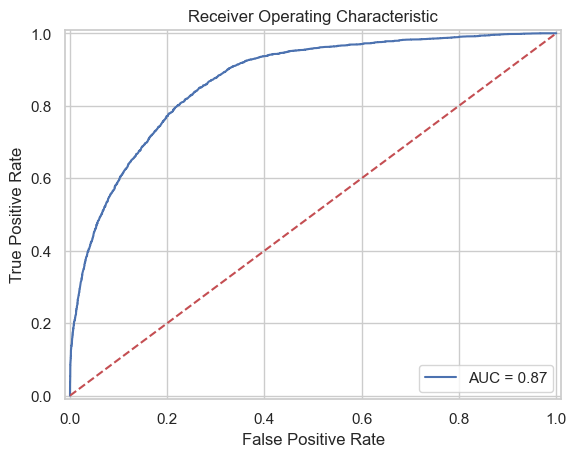

In [72]:
plot_roc_curve(y_test, probs_log)

In [73]:
# k-Nearest Neighbors
start_time = time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors = 3,
                                                                                                 n_jobs = -1), 
                                                                                                 X_train, 
                                                                                                 y_train, 
                                                                                                 X_test, 
                                                                                                 10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 83.01
Accuracy CV 10-Fold: 82.93
Running Time: 0:00:01.562382


In [74]:
print(metrics.classification_report(y_train, train_pred_knn))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     24720
           1       0.65      0.62      0.64      7841

    accuracy                           0.83     32561
   macro avg       0.77      0.76      0.76     32561
weighted avg       0.83      0.83      0.83     32561



In [75]:
print(metrics.classification_report(y_test, test_pred_knn) )


              precision    recall  f1-score   support

           0       0.88      0.89      0.89     12435
           1       0.65      0.62      0.63      3847

    accuracy                           0.83     16282
   macro avg       0.77      0.76      0.76     16282
weighted avg       0.83      0.83      0.83     16282



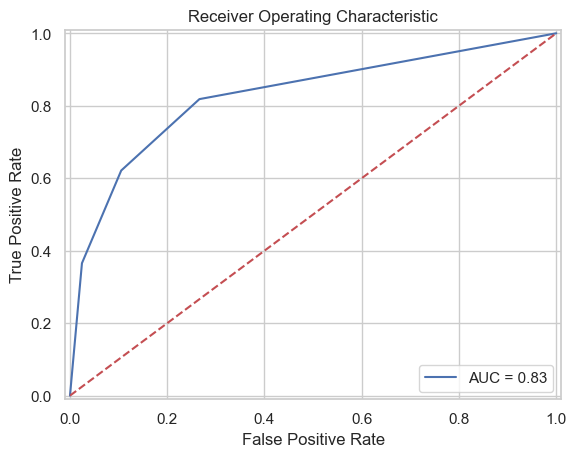

In [76]:
plot_roc_curve(y_test, probs_knn)

In [77]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gau = fit_ml_algo(GaussianNB(), 
                                                                                     X_train, 
                                                                                     y_train, 
                                                                                     X_test, 
                                                                                     10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 81.57
Accuracy CV 10-Fold: 81.24
Running Time: 0:00:00.062865


In [78]:
print(metrics.classification_report(y_train, train_pred_gaussian))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     24720
           1       0.64      0.49      0.56      7841

    accuracy                           0.81     32561
   macro avg       0.75      0.70      0.72     32561
weighted avg       0.80      0.81      0.80     32561



In [79]:
print(metrics.classification_report(y_test, test_pred_gaussian) )

              precision    recall  f1-score   support

           0       0.86      0.91      0.88     12435
           1       0.64      0.50      0.56      3847

    accuracy                           0.82     16282
   macro avg       0.75      0.71      0.72     16282
weighted avg       0.80      0.82      0.81     16282



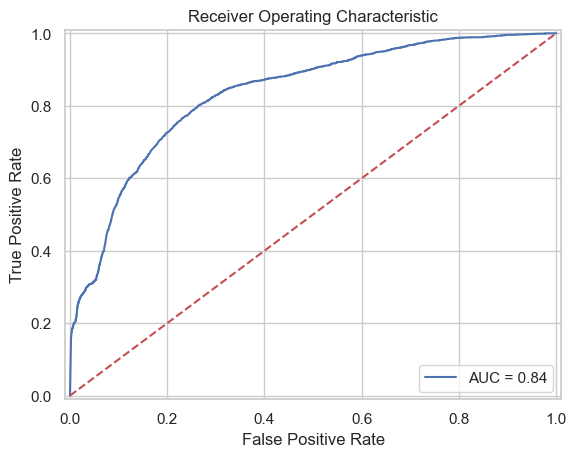

In [80]:
plot_roc_curve(y_test, probs_gau)

In [81]:
# Linear SVC
start_time = time.time()
train_pred_svc, test_pred_svc, acc_linear_svc, acc_cv_linear_svc, _ = fit_ml_algo(LinearSVC(),
                                                                                           X_train, 
                                                                                           y_train,
                                                                                           X_test, 
                                                                                           10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

/Users/klemens.floege/Desktop/Dev/meta-learning-synthetic-data/env/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/klemens.floege/Desktop/Dev/meta-learning-synthetic-data/env/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/klemens.floege/Desktop/Dev/meta-learning-synthetic-data/env/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/klemens.floege/Desktop/Dev/meta-learning-synthetic-data/env/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarnin

Accuracy: 78.79
Accuracy CV 10-Fold: 77.33
Running Time: 0:00:07.599253


/Users/klemens.floege/Desktop/Dev/meta-learning-synthetic-data/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/klemens.floege/Desktop/Dev/meta-learning-synthetic-data/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [82]:
print(metrics.classification_report(y_train, train_pred_svc) )

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     24720
           1       0.53      0.54      0.53      7841

    accuracy                           0.77     32561
   macro avg       0.69      0.69      0.69     32561
weighted avg       0.77      0.77      0.77     32561



In [83]:
print(metrics.classification_report(y_test, test_pred_svc) )

              precision    recall  f1-score   support

           0       0.80      0.97      0.87     12435
           1       0.66      0.21      0.32      3847

    accuracy                           0.79     16282
   macro avg       0.73      0.59      0.60     16282
weighted avg       0.77      0.79      0.74     16282



In [84]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, test_pred_sgd, acc_sgd, acc_cv_sgd, _ = fit_ml_algo(SGDClassifier(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 80.22
Accuracy CV 10-Fold: 79.49
Running Time: 0:00:01.467961


In [85]:
print(metrics.classification_report(y_train, train_pred_sgd) )


              precision    recall  f1-score   support

           0       0.84      0.90      0.87     24720
           1       0.60      0.46      0.52      7841

    accuracy                           0.79     32561
   macro avg       0.72      0.68      0.69     32561
weighted avg       0.78      0.79      0.79     32561



In [86]:
print(metrics.classification_report(y_test, test_pred_sgd) )

              precision    recall  f1-score   support

           0       0.89      0.84      0.87     12435
           1       0.57      0.67      0.62      3847

    accuracy                           0.80     16282
   macro avg       0.73      0.76      0.74     16282
weighted avg       0.82      0.80      0.81     16282



In [87]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 83.64
Accuracy CV 10-Fold: 83.27
Running Time: 0:00:00.376738


In [88]:
print(metrics.classification_report(y_train, train_pred_dt) )

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     24720
           1       0.68      0.58      0.62      7841

    accuracy                           0.83     32561
   macro avg       0.78      0.75      0.76     32561
weighted avg       0.83      0.83      0.83     32561



In [89]:
print(metrics.classification_report(y_test, test_pred_dt) )

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     12435
           1       0.68      0.57      0.62      3847

    accuracy                           0.84     16282
   macro avg       0.78      0.75      0.76     16282
weighted avg       0.83      0.84      0.83     16282



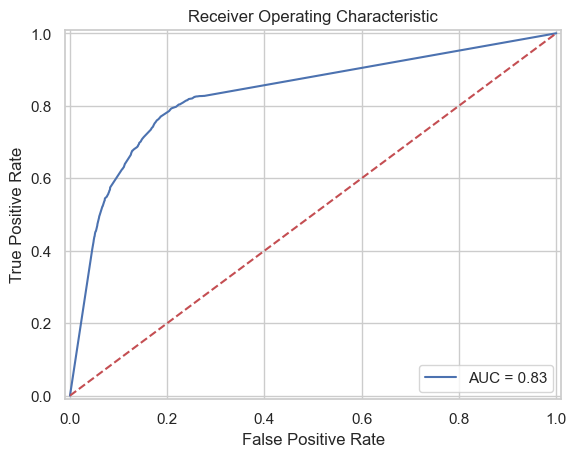

In [90]:
plot_roc_curve(y_test, probs_dt)


In [91]:
# Random Forest Classifier - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Run Randomized Search
n_iter_search = 10
rfc = RandomForestClassifier(n_estimators=10)
random_search = RandomizedSearchCV(rfc, 
                                   n_jobs = -1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 2.34 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.858 (std: 0.005)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 3, 'min_samples_split': 9}

Model with rank: 2
Mean validation score: 0.857 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'min_samples_leaf': 8, 'min_samples_split': 3}

Model with rank: 3
Mean validation score: 0.857 (std: 0.003)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'min_samples_leaf': 4, 'min_samples_split': 11}

Model with rank: 4
Mean validation score: 0.856 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 8, 'min_samples_split': 9}

Model with rank: 5
Mean validation score: 0.855 (std: 0.004)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_dept

In [92]:
# Random Forest Classifier
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10, 
                             min_samples_leaf=2,
                             min_samples_split=17, 
                             criterion='gini', 
                             max_features=8)
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(rfc, 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 85.54
Accuracy CV 10-Fold: 85.55
Running Time: 0:00:00.963571


In [93]:
print(metrics.classification_report(y_train, train_pred_rf) )


              precision    recall  f1-score   support

           0       0.88      0.94      0.91     24720
           1       0.75      0.60      0.67      7841

    accuracy                           0.86     32561
   macro avg       0.82      0.77      0.79     32561
weighted avg       0.85      0.86      0.85     32561



In [94]:
print(metrics.classification_report(y_test, test_pred_rf) )


              precision    recall  f1-score   support

           0       0.88      0.94      0.91     12435
           1       0.75      0.58      0.66      3847

    accuracy                           0.86     16282
   macro avg       0.81      0.76      0.78     16282
weighted avg       0.85      0.86      0.85     16282



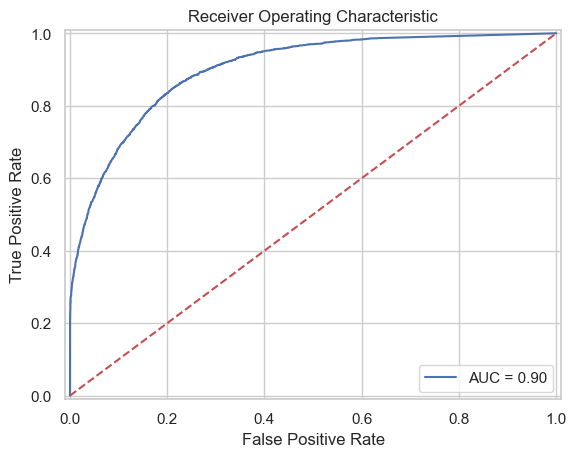

In [95]:
plot_roc_curve(y_test, probs_rf)

In [96]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.28
Accuracy CV 10-Fold: 85.98
Running Time: 0:00:04.702485


In [97]:
print(metrics.classification_report(y_train, train_pred_gbt) )

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     24720
           1       0.78      0.58      0.67      7841

    accuracy                           0.86     32561
   macro avg       0.83      0.76      0.79     32561
weighted avg       0.85      0.86      0.85     32561



In [98]:
print(metrics.classification_report(y_test, test_pred_gbt) )


              precision    recall  f1-score   support

           0       0.88      0.95      0.91     12435
           1       0.79      0.57      0.66      3847

    accuracy                           0.86     16282
   macro avg       0.83      0.76      0.79     16282
weighted avg       0.86      0.86      0.85     16282



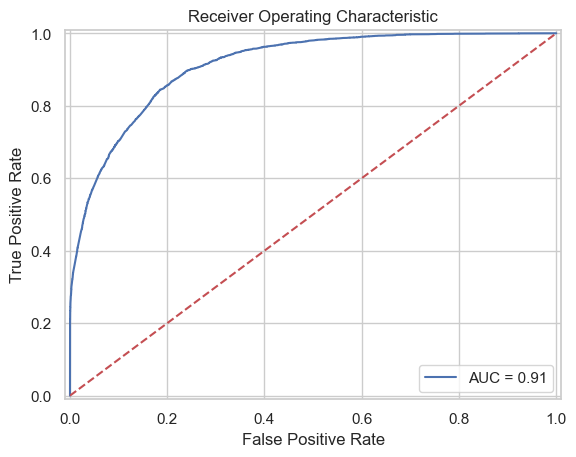

In [99]:
plot_roc_curve(y_test, probs_gbt)


# Ranking Results

In [100]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_knn, 
        acc_log, 
        acc_rf, 
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt
    ]})
models.sort_values(by='Score', ascending=False)

Model  Score
7     Gradient Boosting Trees  86.28
2               Random Forest  85.54
6               Decision Tree  83.64
1         Logistic Regression  83.27
0                         KNN  83.01
3                 Naive Bayes  81.57
4  Stochastic Gradient Decent  80.22
5                  Linear SVC  78.79

In [101]:
#with Cross-Validation
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,     
        acc_cv_rf, 
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt
    ]})
models.sort_values(by='Score', ascending=False)

Model  Score
7     Gradient Boosting Trees  85.98
2               Random Forest  85.55
6               Decision Tree  83.27
1         Logistic Regression  82.99
0                         KNN  82.93
3                 Naive Bayes  81.24
4  Stochastic Gradient Decent  79.49
5                  Linear SVC  77.33

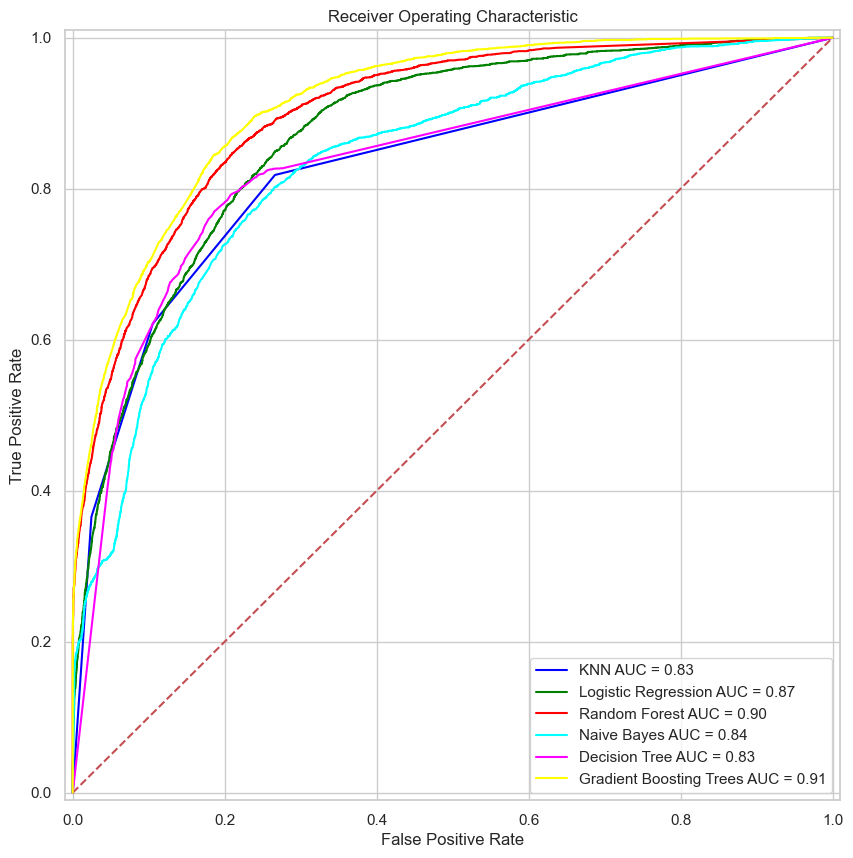

In [102]:

fig = plt.figure(figsize=(10,10)) 

models = [
    'KNN', 
    'Logistic Regression', 
    'Random Forest', 
    'Naive Bayes', 
    'Decision Tree', 
    'Gradient Boosting Trees'
]
probs = [
    probs_knn,
    probs_log,
    probs_rf,
    probs_gau,
    probs_dt,
    probs_gbt
]
colors = [
    'blue',
    'green',
    'red',
    'cyan',
    'magenta',
    'yellow',
]
    
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

def plot_roc_curves(y_test, prob, model):
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = model + ' AUC = %0.2f' % roc_auc, color=colors[i])
    plt.legend(loc = 'lower right')
    
for i, model in list(enumerate(models)):
    plot_roc_curves(y_test, probs[i], models[i])
    
plt.show()

# Tensorflow - Logistic Regression

maybe do later, but tbh does not seem very relevant rn 